In [1]:
library(Seurat)
library(dplyr)
library(tidyverse)
library(doParallel)
library(patchwork)

# source("/share/home/qlab/projects/qlab_yrs/project_ssc/scTools.R")
# 设定下跑数据的内存

# library(future)
# plan("multiprocess", workers = 20)
# plan()
# options(future.globals.maxSize = 20*1000 * 1024^2)


library(scales)
library(slingshot)
library(monocle3)
library(tradeSeq)

library(ggplot2)
library(forcats) # 和 ggplot 一起给数据排序
library(psych)
library(ggrepel)
library(viridis)
library(ggpubr)
library(ggrepel)

library("GSEABase")
library(AUCell)
library(Matrix) 
source("/share/home/qlab/projects/qlab_yrs/scTools.R")
source("/share/home/qlab/projects/qlab_yrs/scPlot.R")
library(ComplexHeatmap)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.5.1     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required package: iterators

Warning mes

In [52]:
library(slingshot)
plotPseudoTime = function(object,
                          group.by = NULL,
                          reduction = 'umap',
                          dims = 1:2,
                          pt.size = 0.5,
                          no.curve = FALSE,
                          colors = NULL,
						  pt.alpha = 0.5
						 ) {
  object[['ident']] <- Idents(object = object)
  group.by <- group.by %||% 'ident'
  dims <- paste0(Seurat::Key(object = object[[reduction]]), dims)

  curved <- bind_rows(lapply(names(object@misc$slingshot$data@metadata$curves), function(x) {
      c <- slingCurves(object@misc$slingshot$data)[[x]]
      d <- as.data.frame(c$s[c$ord, dims])
      d$curve <- x
      return(d)
    }))


  data <- FetchData(object = object, vars = c(dims, group.by))
  p <- ggplot(data, aes_string(x = dims[1], y = dims[2])) +
    geom_point(aes(color =!!sym(group.by)),size = pt.size, alpha = pt.alpha) +
    theme(legend.position = "top")
  if(!is.null(colors)){
     p <- p + scale_color_manual(values = colors)
  }  

  if (is.character(data[[group.by]]) | is.factor(data[[group.by]])){
    p <- p + guides(col = guide_legend(nrow = 2))
  } else {
    p <- p + scale_color_distiller(palette = "YlOrRd", na.value = 'grey90')
    #p <- p + scale_color_distiller(palette = "RdOrYl", na.value = 'grey90')
  }
  if(!no.curve) {
    p <- p + geom_path(aes_string(dims[1], dims[2], linetype = "curve"), curved, size = 1
					  )
  }
  p
}

In [33]:
library(msigdbr)
library(fgsea)
mdb_c2 <- msigdbr(species = "Homo sapiens", category = "C2")
mdb_rec = mdb_c2 [grep("^REACTOME",mdb_c2 $gs_name),]
## 预定义基因集：KEGG+rectome
mdb_c2 <- msigdbr(species = "Homo sapiens", category = "C2")
mdb_kegg = mdb_c2 [grep("^KEGG",mdb_c2 $gs_name),]
mdb_rec = mdb_c2 [grep("^REACTOME",mdb_c2 $gs_name),]
fgsea_kegg_sets <- mdb_kegg %>% split(x = .$gene_symbol, f = .$gs_name)
fgsea_rec_sets <- mdb_rec %>% split(x = .$gene_symbol, f = .$gs_name)
library("hypeR")
# gc()
#draw network
options(browser = "xdg-open")
biosets  <- list()
biosets[["BIOCARTA"]] <- msigdb_gsets(species="Homo sapiens", category="C2", subcategory="CP:BIOCARTA")
biosets[["KEGG"]]     <- msigdb_gsets(species="Homo sapiens", category="C2", subcategory="CP:KEGG")
biosets[["REACTOME"]] <- msigdb_gsets(species="Homo sapiens", category="C2", subcategory="CP:REACTOME")
biosets[["GO"]] <- msigdb_gsets(species="Homo sapiens", category="C5", subcategory="BP")

Warning message:
“程辑包‘hypeR’是用R版本4.3.0 来建造的”


In [3]:
# --- Add annotations for a specific clustering
immune@meta.data$mo_CellType <- as.character(immune@meta.data$mo_CellType)
immune@meta.data$mo_CellType[which(immune@meta.data$mo_CellType == 'Mac_FABP5')] <- 'Mac_SPP1'
immune@meta.data$Site[is.na(immune@meta.data$Site)] <- 'lung'
immune@meta.data$Site[which(immune@meta.data$Site == 'UP')] <- 'lung_UP'
immune@meta.data$Site[which(immune@meta.data$Site == 'LOW')] <- 'lung_LOW'
immune@meta.data$Age[which(immune@meta.data$SamNum %in% c('SScJ1', 'SScJ2'))] <- '54'

ct.res <- data.frame(mo_CellType = immune@meta.data$mo_CellType %>% as.character() %>% unique(),
                     celltype.res.0.1 = 0:(length(immune@meta.data$mo_CellType %>% as.character() %>% unique()) - 1))
meta <- immune@meta.data
immune@meta.data <- meta %>% 
                    rownames_to_column(var = 'barcode') %>%
                    left_join(ct.res, by = 'mo_CellType') %>%
                    column_to_rownames(var = 'barcode')

DefaultAssay(immune) <- 'RNA'
Idents(immune) <- 'celltype.res.0.1'
markers <- FindAllMarkers(immune, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
saveRDS(markers, file = paste0('SnnGenes/ct_res.0.1.rds.gz'), compress = "gzip")

saveRDS(immune, './myeloid.rds')

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6



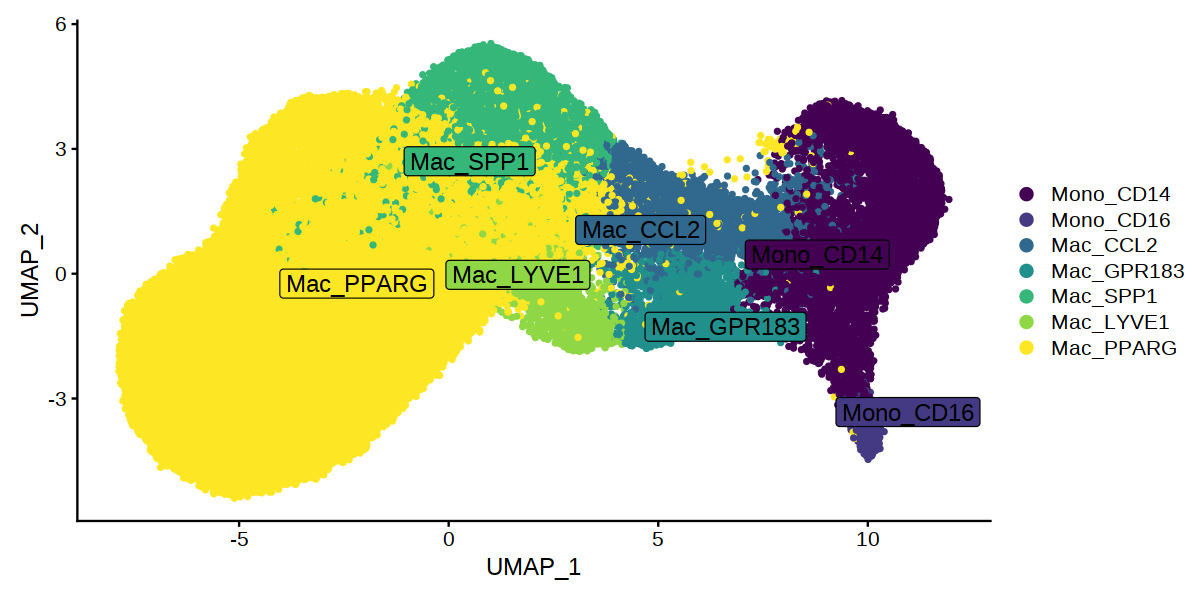

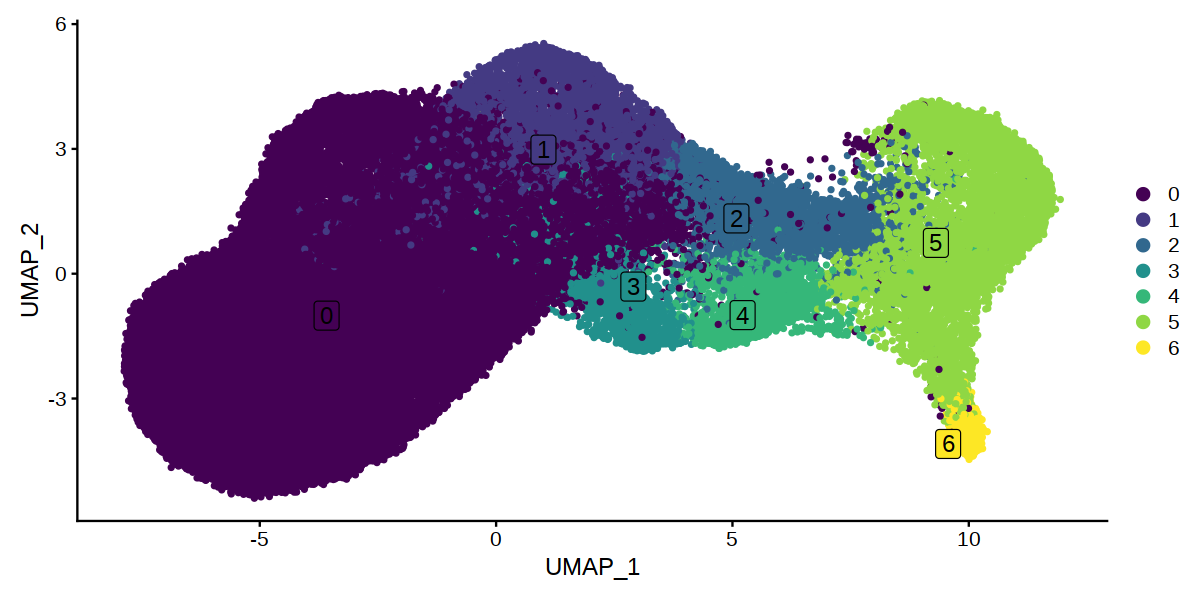

In [2]:
immune <- readRDS('myeloid.rds')
options(repr.plot.height = 5, repr.plot.width = 10)
ct.order <- c('Mono_CD14','Mono_CD16','Mac_CCL2','Mac_GPR183','Mac_SPP1','Mac_LYVE1','Mac_PPARG') 
immune@meta.data$mo_CellType <- factor(immune@meta.data$mo_CellType, levels = ct.order)
Idents(immune) <- 'mo_CellType'
# pdf('./figures/MO_CellType.pdf', width = 7, height = 5)
DimPlot(immune, reduction = "umap", label=TRUE, label.size=5, cols = viridis(7, option = "D"),  label.color = "black",
        label.box = TRUE, pt.size = 1, raster = FALSE, repel = TRUE) 
# dev.off()

# pdf('./figures/Slingshot.pdf',width=15,heigh = 10)
# plotPseudoTime(immune, group.by = "mo_CellType", reduction = "umap",dims = 1:2, pt.size = 1, pt.alpha=0.5,
#                colors = viridis(7, option = "D")) + theme_classic() 
# dev.off()
Idents(immune) <- 'celltype.res.0.1'
DimPlot(immune, reduction = "umap", label=TRUE, label.size=5,  cols = viridis(7, option = "D"), 
        label.color = "black", label.box = TRUE, pt.size = 1, raster = FALSE, repel = TRUE) 

In [4]:
DefaultAssay(immune) <- "RNA"
Idents(immune) <- "mo_CellType"
markers <- FindAllMarkers(immune, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.csv(markers, file="SubCellType_Top_Genes.csv")

Calculating cluster Mono_CD14

Calculating cluster Mono_CD16

Calculating cluster Mac_CCL2

Calculating cluster Mac_GPR183

Calculating cluster Mac_FABP5

Calculating cluster Mac_LYVE1

Calculating cluster Mac_PPARG



In [81]:
# # --- FeaturePlots
# pdf('./figures/Features_Umap.pdf',width=12,height=8)
# DefaultAssay(immune.cluster.order) <- "RNA"
# FeaturePlot(immune.cluster.order, features=c("S100A8","LILRB2","CXCL8","GPR183","RGS1","FOLR2","CCL18", "FABP4"))
# dev.off()

# DefaultAssay(immune.cluster.order) <- 'RNA'
# Idents(immune.cluster.order)<-"mo_CellType"
# # pdf(file='./figures/Features_Vln.pdf')
# VlnPlot(immune.cluster.order, cols = viridis(12, option = "G"),
#         features = c("S100A8","CORO1A","LILRB2","IL1B","CXCL8","GPR183",'CCL3',"RGS1","FOLR2","CCL18",
#             "FABP4","INHBA"
#                                       ),#Alveolar_mac
#         slot = "data",stack=TRUE, flip = T, adjust = 2)
# dev.off()

In [5]:
# # --- Plot Mrkers in each clusters
# options(repr.plot.height = 6, repr.plot.width = 5)
# Idents(immune) <- 'mo_CellType'
# immune@meta.data$mo_CellType <- factor(immune@meta.data$mo_CellType, levels = ct.order)
# markers <- FindAllMarkers(immune, assay = 'RNA', only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
# top10 <- markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)

mrk.gene <- c('FCN1', 'CD68', 
                'CD14', 'S100A8', 
                'FCGR3A', 'MTSS1', 
                'CCL2', 'CXCL8', 
                'GPR183', 'CLEC10A', 
                'SPP1','FABP5', 'PLA2G7', 
                'LYVE1', 'FOLR2', 'SEPP1', 
                'PPARG', 'FABP4', 'INHBA')
pdf('./figures/HM_mrkgenes.pdf', width = 5, height= 6)
averageHeatmap(object = immune, markerGene = mrk.gene, annoCol = TRUE, myanCol = viridis(7, option = "D"))
dev.off()

# # --- HM：severarl pathway genes
# options(repr.plot.height = 6, repr.plot.width = 5)
# DefaultAssay(immune) <- 'AUC'
# Idents(immune) <- 'mo_CellType'

# mrk.path <- c('REACTOME-ALTERNATIVE-COMPLEMENT-ACTIVATION', 
#             'REACTOME-SYNTHESIS-OF-BILE-ACIDS-AND-BILE-SALTS-VIA-24-HYDROXYCHOLESTEROL', 
#             'REACTOME-MRNA-SPLICING', 
#             'REACTOME-REGULATION-OF-INSULIN-LIKE-GROWTH-FACTOR-IGF-TRANSPORT-AND-UPTAKE-BY-INSULIN-LIKE-GROWTH-FACTOR-BINDING-PROTEINS-IGFBPS', 
#             'REACTOME-COLLAGEN-FORMATION', 
#             'REACTOME-EXTRACELLULAR-MATRIX-ORGANIZATION', 
#             'REACTOME-MOLECULES-ASSOCIATED-WITH-ELASTIC-FIBRES', 
#             'REACTOME-INTEGRIN-CELL-SURFACE-INTERACTIONS', 
#             'REACTOME-CELL-CELL-COMMUNICATION',
#             'REACTOME-HSF1-ACTIVATION',
#             'REACTOME-ATTENUATION-PHASE', 
#             'REACTOME-METALLOTHIONEINS-BIND-METALS',  
#             'REACTOME-SMOOTH-MUSCLE-CONTRACTION', 
#             'REACTOME-RHO-GTPASES-ACTIVATE-ROCKS',
#             'REACTOME-CELL-EXTRACELLULAR-MATRIX-INTERACTIONS', 
#             'REACTOME-NOTCH3-INTRACELLULAR-DOMAIN-REGULATES-TRANSCRIPTION', 
#             'REACTOME-ELECTRIC-TRANSMISSION-ACROSS-GAP-JUNCTIONS',             
#             'REACTOME-TIGHT-JUNCTION-INTERACTIONS', 
#             'REACTOME-FCGR-ACTIVATION', 
#             'REACTOME-CELLULAR-RESPONSE-TO-STARVATION'
# )
# pdf('./figures/HM_Pathway_in_fibCT.pdf', width = 5, height = 6)
# averageHeatmap(object = immune, markerGene = mrk.path, assays = 'AUC', annoCol = TRUE, myanCol = viridis(7, option = "D"))
# dev.off()

png 
  2

In [11]:
# --- HMplot of MrkGenes in mo_CellType
options(repr.plot.height = 10, repr.plot.width = 4)
inflam.genes <- c('IL1B', 'SOCS3','TNF', 'CXCL10','CXCL8', 'CXCL2', 'CXCL9', 'CCL2', 'CCL3')
anti.inflam.genes <- c('IL10', 'GPNMB', 'CCL18', 'CCL13',
    'CD163', 'MRC1', 'FOLR2', 'STAB1', 'CD163L1', 'SEPP1', 'F13A1', 'MERTK', 'MSR1', 'AXL')
mmp.genes <- c('MMP1', 'MMP7', 'MMP9', 'MMP11', 'MMP12', 'MMP14')
atg.genes <- c('B2M','HLA-A', 'HLA-C', 'HLA-DRB1', 'HLA-DQB2', 'HLA-DPA1')
fibro.genes <- c('SPP1', 'FABP5', 'PLA2G7', 'CHI3L1', 'SPARC')
mrk.gene <- c(inflam.genes, anti.inflam.genes, mmp.genes, atg.genes, fibro.genes)

sam.avg <- AverageExpression(immune, assays = 'RNA', group.by = 'mo_CellType')
hm.df <- sam.avg$RNA %>% t() %>% as.data.frame() %>% .[, mrk.gene] %>% scale(scale = TRUE, center = TRUE)

# info <- immune@meta.data[, c('Group', 'mo_CellType')] %>% unique() %>% {rownames(.) <- NULL; .} %>% column_to_rownames(var = 'mo_CellType') 

# ann_colors=list(EC_CellType = c(Mono_CD14 = '#440154FF', Mono_CD16 = '#443A83FF', Mac_CCL2 =  '#31688EFF',  Mac_GPR183 = '#21908CFF', Mac_FABP5 ='#35B779FF', Mac_LYVE1 = '#8FD744FF', Mac_PPARG = '#FDE725FF'),
                # Group = c(SSC = "#B17AA1", HC = "#184995"))
# ct.list <- c('HC|alveolar capillary', 'SSC|alveolar capillary',
#             'HC|extra-alveolar capillary', 'SSC|extra-alveolar capillary',
#             'HC|immature', 'SSC|immature', 
#             'HC|post-capillary venule', 'SSC|post-capillary venule', 
#             'HC|vein', 'SSC|vein',
#             'HC|artery', 'SSC|artery')
pdf('./figures/HM_GeneExp_in_Groups.pdf', width = 4, height = 8)
hm <- pheatmap(hm.df %>% t(), cluster_row = FALSE, cluster_col = FALSE, # pheatmap(hm.df[ct.list,] %>% t(), cluster_row = FALSE, cluster_col = FALSE, 
            color = c(colorRampPalette(colors = c("darkblue","white"))(50),colorRampPalette(colors = c("white", "red"))(50)), 
            main = ("Scale_Express"),
             # annotation_col = info[,c('EC_CellType','Group')],
             # annotation_colors = ann_colors,
             gaps_row = c(
                        length(inflam.genes),
                        length(inflam.genes) + length(anti.inflam.genes), 
                        length(c(inflam.genes, anti.inflam.genes))+length(mmp.genes),
                        length(c(inflam.genes, anti.inflam.genes, mmp.genes)) + length(atg.genes))
            # gaps_col = c(2,4,6,8,10)
            ) 
print(hm)
dev.off()

png 
  2

In [116]:
# 然后画hc vs ssc的heatmap：
# fibrosis （SPP1, SPARC, FN1, TIMP1, TAGLN2 TGFBI) , 
# inflammatory (IL1B, CCL2, CCL3, CCL7, CXCL8)
# interferon(ISG15, IFI4, IFI6, IFI44, IFNAR1, STAT1)
# hypoxia (VEGFA, ENO1, PAGM1,MIF), anti-inflammatory

# --- HM：severarl pathway genes
options(repr.plot.height = 12, repr.plot.width = 8)
DefaultAssay(immune) <- 'RNA'
immune@meta.data$hm_group <- paste0(immune@meta.data$Group, '|', immune@meta.data$mo_CellType)
Idents(immune) <- 'hm_group'
immune@meta.data$hm_group <- factor(immune@meta.data$hm_group,
                                              levels = c('HC|Mono_CD14', 'SSC|Mono_CD14',
                                                         'HC|Mono_CD16', 'SSC|Mono_CD16',
                                                         'HC|Mac_CCL2', 'SSC|Mac_CCL2', 
                                                         'HC|Mac_GPR183', 'SSC|Mac_GPR183', 
                                                         'HC|Mac_FABP5', 'SSC|Mac_FABP5',
                                                         'HC|Mac_LYVE1', 'SSC|Mac_LYVE1',
                                                         'HC|Mac_PPARG', 'SSC|Mac_PPARG'))
fib.genes <- c('SPP1', 'SPARC', 'FN1', 'TIMP1', 'TAGLN2', 'TGFBI')
ifm.genes <- c('IL1B', 'CCL2', 'CCL3', 'CCL7', 'CXCL8') # inflammatory
ifn.genes <- c('ISG15', 'IFI6', 'IFI44', 'IFNAR1', 'STAT1') # 'IFI4',
hypo.genes <- c('VEGFA', 'ENO1', 'PGAM1', 'MIF') 
anti_ifm.genes <- c('IL10', 'GPNMB', 'CCL22', 'CCL18', 'CCL13', 'CD163', 'MRC1', 'FOLR2', 'STAB1', 'CD163L1', 'SEPP1', 'F13A1', 'MERTK', 'CHI3L1' ,'MSR1', 'AXL')

mrk.genes <- c(fib.genes, ifm.genes, ifn.genes, hypo.genes, anti_ifm.genes) %>% unique()

sam.avg <- AverageExpression(immune, assays = 'RNA', group.by = 'hm_group')
hm.df <- sam.avg$RNA %>% t() %>% as.data.frame() %>% .[, mrk.genes] %>% scale(scale = TRUE, center = TRUE)

info <- immune@meta.data[, c('hm_group', 'Group', 'mo_CellType')] %>% unique() %>% {rownames(.) <- NULL; .} %>% column_to_rownames(var = 'hm_group') 

ann_colors=list(mo_CellType = c(`Mono_CD14` = '#FDE725FF', `Mono_CD16` = '#440154FF', Mac_CCL2 = '#2A788EFF',  `Mac_GPR183` = '#22A884FF', 
                                Mac_FABP5 = '#414487FF', Mac_LYVE1 = '#7AD151FF', Mac_PPARG = 'black'),
                Group = c(SSC = "#B17AA1", HC = "#184995"))
ct.list <- c('HC|Mono_CD14', 'SSC|Mono_CD14',
             'HC|Mono_CD16', 'SSC|Mono_CD16',
             'HC|Mac_CCL2', 'SSC|Mac_CCL2', 
             'HC|Mac_GPR183', 'SSC|Mac_GPR183', 
             'HC|Mac_FABP5', 'SSC|Mac_FABP5',
             'HC|Mac_LYVE1', 'SSC|Mac_LYVE1',
             'HC|Mac_PPARG', 'SSC|Mac_PPARG')
pdf('./figures/HM_GeneExp_in_Groups.pdf', width = 10, height = 10)
hm <- pheatmap(hm.df[ct.list,] %>% t(), cluster_row = FALSE, cluster_col = FALSE, 
            color = c(colorRampPalette(colors = c("darkblue","white"))(50),colorRampPalette(colors = c("white", "red"))(50)), 
            main = ("Scale_Express"),
             annotation_col = info[,c('mo_CellType','Group')],
             annotation_colors = ann_colors,
             gaps_row = c(
                        length(fib.genes),
                        length(fib.genes) + length(ifm.genes), 
                        length(c(fib.genes, ifm.genes)) + length(ifm.genes),
                        length(c(fib.genes, ifm.genes, ifm.genes)) + length(hypo.genes)),
                        # length(c(fib.genes, ifm.genes, ifm.genes))+length(death.genes)),
            gaps_col = c(2,4,6,8,10,12)
            ) 
print(hm)
dev.off()

Warning message:
“Column annotation has different order from matrix columns. Adjust the
column annotation based on column names of the matrix.”


png 
  2

In [4]:
# --- plot DEGs in each mo_CellType
immune.f0 <- subset(immune, Cohort %in% c('ev', 'paul'))
data <- NULL
for(ct in ct.order){
    immune.f <- subset(immune.f0, mo_CellType == ct)
    DefaultAssay(immune.f) <- 'RNA'
    cell.ssc <- immune.f@meta.data %>% subset(Group == 'SSC') %>% rownames()
    cell.hc <- immune.f@meta.data %>% subset(Group == 'HC') %>% rownames()
    diff <- FindMarkers(immune.f, min.pct = 0.01, logfc.threshold = 0.2, ident.1 = cell.ssc, ident.2 = cell.hc) %>% rownames_to_column(var = "gene")
    diff$mo_CellType <- ct
    data <- rbind(data, diff)
}
data %>% mutate(Compare = 'SSC_VS_HC') %>% write.csv('Figure5.e.csv', row.names = F)
# library(ggsci)
# diff.all <- data
# diff.all$sig <- 'no'
# diff.all$sig[which(diff.all$p_val_adj < 0.05 & diff.all$avg_log2FC > 0.5)] <- 'up'
# diff.all$sig[which(diff.all$p_val_adj < 0.05 & diff.all$avg_log2FC < -0.5)] <- 'down'
# diff.all$label <- ''
# diff.all$label[which(diff.all$sig %in% c('down', 'up'))] <- diff.all$gene[which(diff.all$sig %in% c('down', 'up'))] 
# diff.all$mo_CellType <- factor(diff.all$mo_CellType,
#                               levels = ct.order)

# dfcol<- data.frame(x = ct.order, y = 0, label = ct.order)
# dfcol$label <- factor(dfcol$label, levels = ct.order)
# mycol <- pal_d3("category20")(7)
# # --- Count DEGs numbers
# deg.num.df <- diff.all %>% dplyr::filter(sig %in% c('up', 'down')) %>% 
#                 group_by(mo_CellType, sig) %>% summarise(num = n()) %>%
#                 as.data.frame() %>% mutate(num_new = ifelse(sig == 'up', num, -num))
# # # --- set specifically displayed genes
# # hypoxia.rec.genesets <- c('ARNT', 'CA9', 'CREBBP', 'EP300', 'EPAS1', 'EPO', 'HIF1A', 'ELOC', 'ELOB', 'VEGFA', 
# #                           'VHL','CUL2', 'RBX1', 'CITED2', 'HIGD1A', 'HIF1AN', 'HIF3A', 'EGLN2', 'EGLN3')
# # diff.all$label_hypo <-''
# # diff.all$label_hypo[which(diff.all$gene %in% hypoxia.rec.genesets)] <- diff.all$gene[which(diff.all$gene %in% hypoxia.rec.genesets)]
# # diff.all$label_hypo[which(diff.all$sig == 'no')] <- ''

# # O2_CO2.rec.genesets <- c('AQP1', 'CA1', 'CA2', 'CA4', 'HBA2', 'HBB', 'RHAG', 'SLC4A1')
# # diff.all$label_o2 <-''
# # diff.all$label_o2[which(diff.all$gene %in% O2_CO2.rec.genesets)] <- diff.all$gene[which(diff.all$gene %in% O2_CO2.rec.genesets)]
# # diff.all$label_o2[which(diff.all$sig == 'no')] <- ''

# options(repr.plot.height = 6, repr.plot.width = 12)
# diff.all$sig = factor(diff.all$sig, levels = c('down', 'no', 'up'))
# ggplot()+
#     # --- plot total degs
#     # geom_bar(data= deg.num.df, aes(x = mo_CellType, y = num_new/100), stat="identity", fill = 'grey', alpha = 0.5) + 
#     # geom_text(data= deg.num.df, aes(x = mo_CellType, y = num_new/100, label = num), vjust = -0.5)+
#     # --- plot dot
#     geom_jitter(data = diff.all %>% dplyr::filter(sig == "no"), 
#                 aes(x = mo_CellType, y = avg_log2FC, color = sig), size = 1, width = 0.4, alpha = 0.5) +
#     geom_jitter(data = diff.all %>% dplyr::filter(sig %in% c('down', 'up')), # %>% dplyr::filter(label_hypo == '' & label_o2 == ''), 
#                 aes(x = mo_CellType, y = avg_log2FC, color = sig), size = 1.5, width = 0.4, alpha = 0.5) +  
#     # geom_jitter(data = diff.all %>% dplyr::filter(label_hypo != ''), 
#     #             aes(x = mo_CellType, y = avg_log2FC), size = 2, stroke = 0.5, shape = 21, color = 'black', fill = '#6B8770', width = 0.4, alpha = 0.75) +
#     # geom_jitter(data = diff.all %>% dplyr::filter(label_o2 != ''), 
#     #             aes(x = mo_CellType, y = avg_log2FC), size = 2, stroke = 0.5, shape = 21, color = 'black', fill = 'orange', width = 0.4, alpha = 0.75) +
#     scale_color_manual(values = c("grey","#184995","#B17AA1")) +
#     # --- plot label
#     geom_text_repel(data = diff.all, #%>% dplyr::filter(label_hypo == '' & label_o2 == ''), 
#                     aes(x = mo_CellType, y = avg_log2FC, label=label, color = sig), 
#                     size = 3, force = 0.5, max.overlaps = 15) +
#     # geom_text(data = diff.all %>% dplyr::filter(label_hypo != ''), 
#     #                 aes(x = mo_CellType, y = avg_log2FC, label=label_hypo), 
#     #                 size = 3, color = 'black', force = 0.5, max.overlaps = 15
#     #                )+
#     # geom_text(data = diff.all %>% dplyr::filter(label_o2 != ''), 
#     #                 aes(x = mo_CellType, y = avg_log2FC, label=label_o2),
#     #                 size = 3, color = 'black', force = 0.5, max.overlaps = 15, 
#     #                 arrow = arrow(length = unit(0.008, "npc"), type = "open", ends = "last")
#     #                )+
#     geom_tile(data = dfcol, aes(x=x, y=y), height=0.5, color = "black", fill = mycol, alpha = 0.8, show.legend = F) +
#     geom_text(data = dfcol, aes(x=x, y=y,label=x), size = 5 , color ="black") +
#     labs(x="mo_CellType", y="avg_log2FC") +
#     # scale_y_continuous(sec.axis = sec_axis(~.*100, name = 'number of sigDEGs')) +
#     theme_bw() +  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6)) +
#     ggtitle('SSC VS HC in each mo_CellType') 
# # ggsave('./figures/DEGs_in_fibCellType.pdf', width = 8, heigh = 5)

# ggplot() + 
# geom_bar(data= deg.num.df, aes(x = mo_CellType, y = num,  fill = sig), stat="summary", fun='mean', position = position_dodge(), alpha = 0.5) +
# scale_fill_manual(values = c("#184995", "#B17AA1")) +
# theme_classic()
# # ggsave('./figures/DEGsNumber_in_fibCellType.pdf', width = 7, heigh = 5)

In [41]:
# --- plot DETFs in each mo_CellType
immune.f0 <- subset(immune, Cohort %in% c('ev', 'paul'))
data <- NULL
for(ct in ct.order){
    immune.f <- subset(immune.f0, mo_CellType == ct)
    DefaultAssay(immune.f) <- 'TF'
    cell.ssc <- immune.f@meta.data %>% subset(Group == 'SSC') %>% rownames()
    cell.hc <- immune.f@meta.data %>% subset(Group == 'HC') %>% rownames()
    diff <- FindMarkers(immune.f, min.pct = 0.01, logfc.threshold = 0.2, ident.1 = cell.ssc, ident.2 = cell.hc) %>% rownames_to_column(var = "gene")
    diff$mo_CellType <- ct
    data <- rbind(data, diff)
}
write.csv(data, 'mo_DETFs_CT.csv')

In [34]:
# Enriched Pathway in SSC of each mo_CellType
diff.all <- data
# pdf('./figures/upDEGs_Reactome.pdf', width =12, height =6)
for(i in seq_along(ct.order)){
    c1.gene = diff.all %>% dplyr::filter(p_val < 0.05 & avg_log2FC > 0 & mo_CellType == ct.order[i]) %>% 
            arrange(-avg_log2FC) %>% pull(gene) %>% .[1:200]
    geneset  <- biosets[['REACTOME']]
    if(length(geneset$genesets[duplicated(geneset$genesets)]) >0){geneset$genesets <- geneset$genesets[!duplicated(geneset$genesets)]}
    hyp_obj <- hypeR(c1.gene, geneset,test="hypergeometric", background=30000)
    hyp_obj$data$label <- str_replace(hyp_obj$data$label, 'REACTOME_', '')
    
    pdf(paste0('./figures/ct_reactome/', ct.order[i], '_plot.pdf'), width = 4, height = 6)
    p.plot <- hyp_obj$data %>% dplyr::filter(fdr < 0.01 & pval < 0.05 & overlap > 9) %>% 
            mutate(pathway = fct_reorder(label, -fdr), GeneNum = overlap) %>%
            ggplot(aes(x = -log(pval), y = pathway)) +
                geom_point(aes(size = GeneNum, color = -log(fdr))) +
                scale_color_gradient(low="#136885",high = "#FAB35B") +
                theme_bw() + labs(color = "-Log(FDR)") +
                ggtitle(paste0(gsub("(\\D)(\\D+)", "\\U\\1\\L\\2", ct.order[i], perl = TRUE),': enriched Reactome pathways')) + 
                theme(axis.text.y = element_blank())
    print(p.plot)
    dev.off()
        
    pdf(paste0('./figures/ct_reactome/', ct.order[i], '_yaxis.pdf'), width = 12, height = 6)        
    p.y <- hyp_obj$data %>% dplyr::filter(fdr < 0.01 & pval < 0.05 & overlap > 9) %>% 
            mutate(pathway = fct_reorder(label, -fdr), GeneNum = overlap) %>%
            ggplot(aes(x = -log(pval), y = pathway)) +
                geom_point(aes(size = GeneNum, color = -log(fdr))) +
                scale_color_gradient(low="#136885",high = "#FAB35B") +
                theme_bw() + labs(color = "-Log(FDR)") +
                ggtitle(paste0(gsub("(\\D)(\\D+)", "\\U\\1\\L\\2", ct.order[i], perl = TRUE),': enriched Reactome pathways')) 
    print(p.y)
    dev.off()
}
# dev.off()

`summarise()` has grouped output by 'mo_CellType'. You can override using the `.groups` argument.
Warning message:
“ggrepel: 40 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


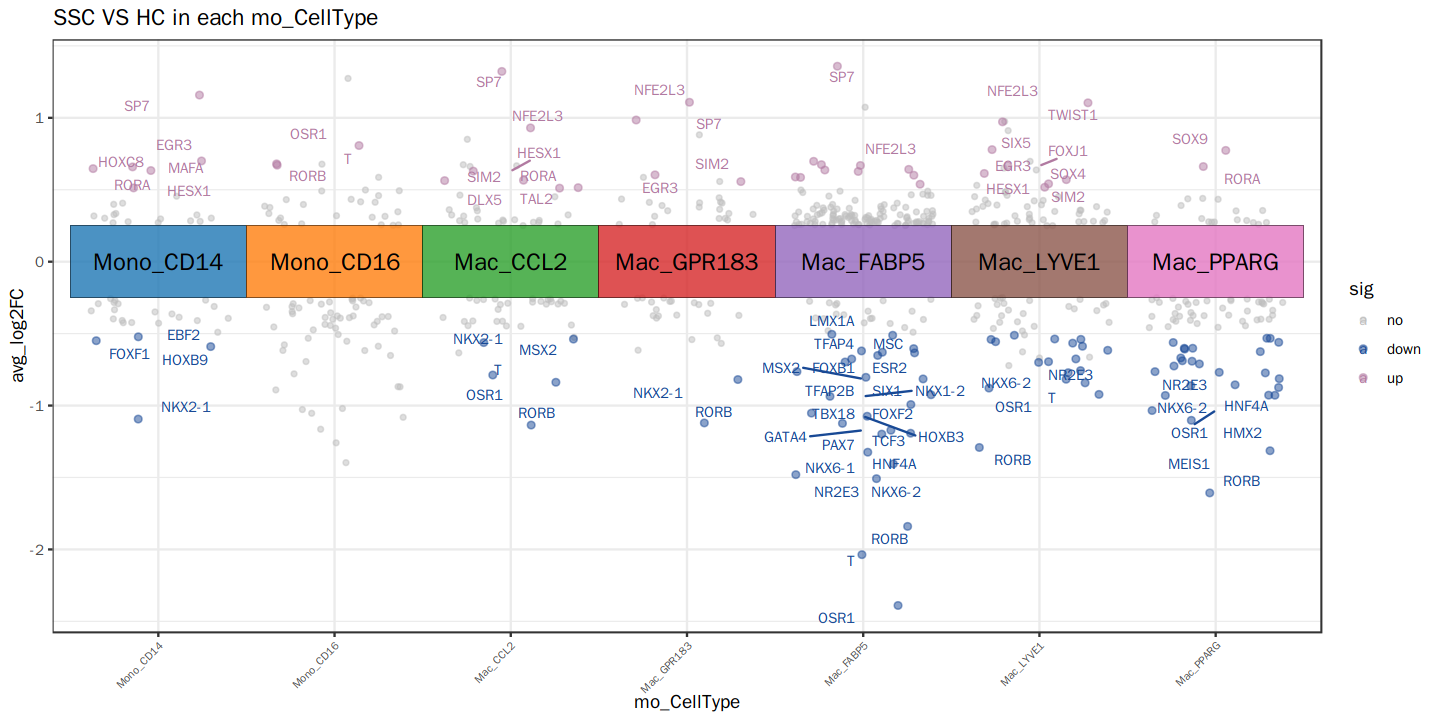

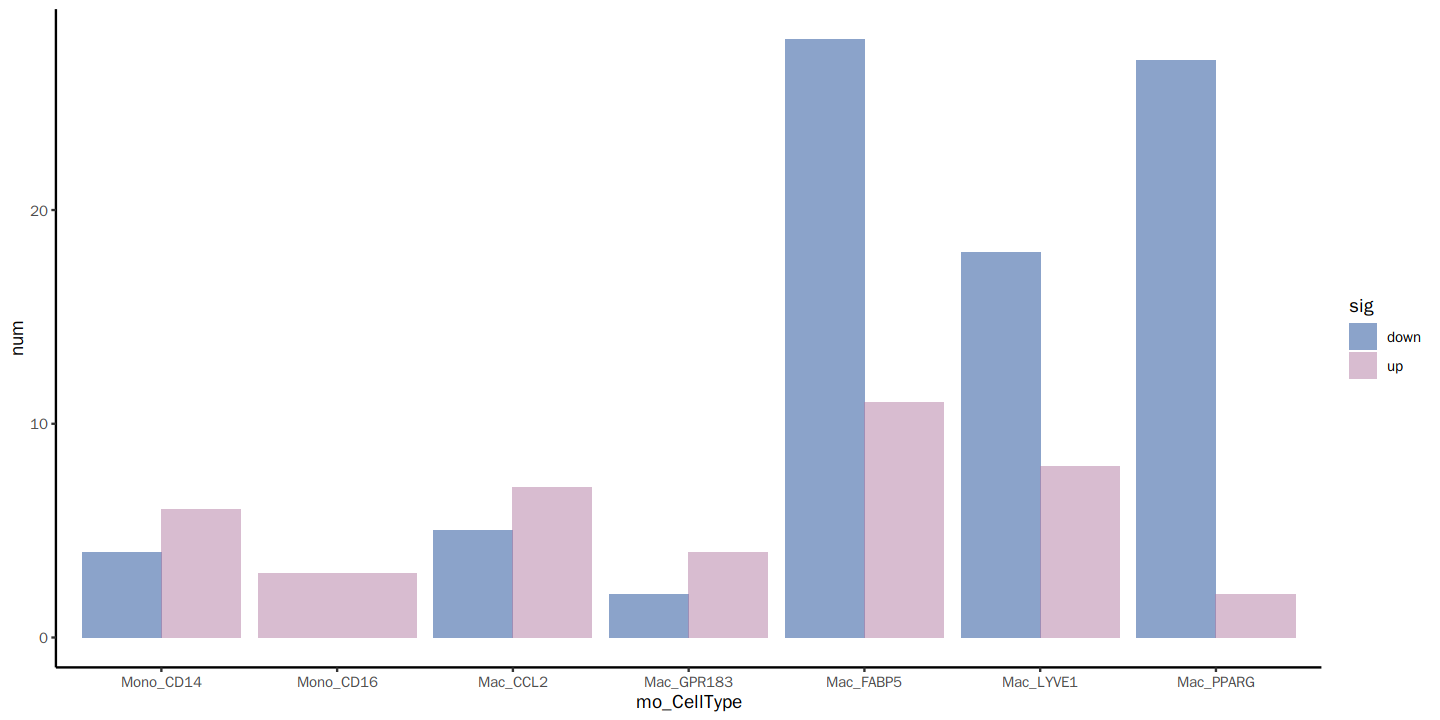

In [70]:
# # --- plot DEGs_TF in each mo_CellType
# immune.f0 <- subset(immune, Cohort %in% c('ev', 'paul'))
# data <- NULL
# for(ct in ct.order){
#     immune.f <- subset(immune.f0, mo_CellType == ct)
#     DefaultAssay(immune.f) <- 'TF'
#     cell.ssc <- immune.f@meta.data %>% subset(Group == 'SSC') %>% rownames()
#     cell.hc <- immune.f@meta.data %>% subset(Group == 'HC') %>% rownames()
#     diff <- FindMarkers(immune.f, min.pct = 0.01, ident.1 = cell.ssc, ident.2 = cell.hc, pseudocount.use = 0.001) %>% rownames_to_column(var = "gene")
#     diff$mo_CellType <- ct
#     data <- rbind(data, diff)
# }
write.csv(data, 'DEtfs_mo_CellType.csv')
library(ggsci)
diff.all <- data
diff.all$sig <- 'no'
diff.all$sig[which(diff.all$p_val_adj < 0.05 & diff.all$avg_log2FC > 0.5)] <- 'up'
diff.all$sig[which(diff.all$p_val_adj < 0.05 & diff.all$avg_log2FC < -0.5)] <- 'down'
diff.all$label <- ''
diff.all$label[which(diff.all$sig %in% c('down', 'up'))] <- diff.all$gene[which(diff.all$sig %in% c('down', 'up'))] 
diff.all$mo_CellType <- factor(diff.all$mo_CellType,
                              levels = ct.order)

dfcol<- data.frame(x = ct.order, y = 0, label = ct.order)
dfcol$label <- factor(dfcol$label, levels = ct.order)
mycol <- pal_d3("category20")(7)
# --- Count DEGs numbers
deg.num.df <- diff.all %>% dplyr::filter(sig %in% c('up', 'down')) %>% 
                group_by(mo_CellType, sig) %>% summarise(num = n()) %>%
                as.data.frame() %>% mutate(num_new = ifelse(sig == 'up', num, -num))
# # --- set specifically displayed genes
# hypoxia.rec.genesets <- c('ARNT', 'CA9', 'CREBBP', 'EP300', 'EPAS1', 'EPO', 'HIF1A', 'ELOC', 'ELOB', 'VEGFA', 
#                           'VHL','CUL2', 'RBX1', 'CITED2', 'HIGD1A', 'HIF1AN', 'HIF3A', 'EGLN2', 'EGLN3')
# diff.all$label_hypo <-''
# diff.all$label_hypo[which(diff.all$gene %in% hypoxia.rec.genesets)] <- diff.all$gene[which(diff.all$gene %in% hypoxia.rec.genesets)]
# diff.all$label_hypo[which(diff.all$sig == 'no')] <- ''

# O2_CO2.rec.genesets <- c('AQP1', 'CA1', 'CA2', 'CA4', 'HBA2', 'HBB', 'RHAG', 'SLC4A1')
# diff.all$label_o2 <-''
# diff.all$label_o2[which(diff.all$gene %in% O2_CO2.rec.genesets)] <- diff.all$gene[which(diff.all$gene %in% O2_CO2.rec.genesets)]
# diff.all$label_o2[which(diff.all$sig == 'no')] <- ''

options(repr.plot.height = 6, repr.plot.width = 12)
diff.all$sig = factor(diff.all$sig, levels = c('down', 'no', 'up'))
ggplot()+
    # --- plot total degs
    # geom_bar(data= deg.num.df, aes(x = mo_CellType, y = num_new/100), stat="identity", fill = 'grey', alpha = 0.5) + 
    # geom_text(data= deg.num.df, aes(x = mo_CellType, y = num_new/100, label = num), vjust = -0.5)+
    # --- plot dot
    geom_jitter(data = diff.all %>% dplyr::filter(sig == "no"), 
                aes(x = mo_CellType, y = avg_log2FC, color = sig), size = 1, width = 0.4, alpha = 0.5) +
    geom_jitter(data = diff.all %>% dplyr::filter(sig %in% c('down', 'up')), # %>% dplyr::filter(label_hypo == '' & label_o2 == ''), 
                aes(x = mo_CellType, y = avg_log2FC, color = sig), size = 1.5, width = 0.4, alpha = 0.5) +  
    # geom_jitter(data = diff.all %>% dplyr::filter(label_hypo != ''), 
    #             aes(x = mo_CellType, y = avg_log2FC), size = 2, stroke = 0.5, shape = 21, color = 'black', fill = '#6B8770', width = 0.4, alpha = 0.75) +
    # geom_jitter(data = diff.all %>% dplyr::filter(label_o2 != ''), 
    #             aes(x = mo_CellType, y = avg_log2FC), size = 2, stroke = 0.5, shape = 21, color = 'black', fill = 'orange', width = 0.4, alpha = 0.75) +
    scale_color_manual(values = c("grey","#184995","#B17AA1")) +
    # --- plot label
    geom_text_repel(data = diff.all, #%>% dplyr::filter(label_hypo == '' & label_o2 == ''), 
                    aes(x = mo_CellType, y = avg_log2FC, label=label, color = sig), 
                    size = 3, force = 0.5, max.overlaps = 15) +
    # geom_text(data = diff.all %>% dplyr::filter(label_hypo != ''), 
    #                 aes(x = mo_CellType, y = avg_log2FC, label=label_hypo), 
    #                 size = 3, color = 'black', force = 0.5, max.overlaps = 15
    #                )+
    # geom_text(data = diff.all %>% dplyr::filter(label_o2 != ''), 
    #                 aes(x = mo_CellType, y = avg_log2FC, label=label_o2),
    #                 size = 3, color = 'black', force = 0.5, max.overlaps = 15, 
    #                 arrow = arrow(length = unit(0.008, "npc"), type = "open", ends = "last")
    #                )+
    geom_tile(data = dfcol, aes(x=x, y=y), height=0.5, color = "black", fill = mycol, alpha = 0.8, show.legend = F) +
    geom_text(data = dfcol, aes(x=x, y=y,label=x), size = 5 , color ="black") +
    labs(x="mo_CellType", y="avg_log2FC") +
    # scale_y_continuous(sec.axis = sec_axis(~.*100, name = 'number of sigDEGs')) +
    theme_bw() +  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6)) +
    ggtitle('SSC VS HC in each mo_CellType') 
# ggsave('./figures/DEGs_in_fibCellType.pdf', width = 8, heigh = 5)

ggplot() + 
geom_bar(data= deg.num.df, aes(x = mo_CellType, y = num,  fill = sig), stat="summary", fun='mean', position = position_dodge(), alpha = 0.5) +
scale_fill_manual(values = c("#184995", "#B17AA1")) +
theme_classic()
# ggsave('./figures/DEGsNumber_in_fibCellType.pdf', width = 7, heigh = 5)

`summarise()` has grouped output by 'SamNum'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'SamNum', 'Group'. You can override using the `.groups` argument.


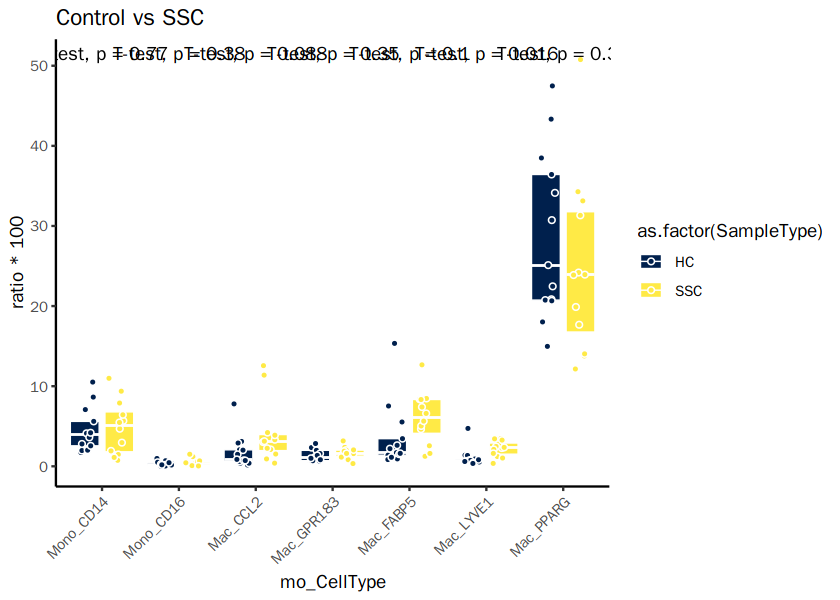

In [62]:
## 绘制 Control 和 SSC 样本中不同细胞类型的差异
# ssc <- readRDS("/share/home/qlab/projects/qlab_yrs/project_ssc/data/object/all/sam_df_anno_SSC.rds")
classifier  <- "Group"
metadata.df  <- immune@meta.data %>%
  tibble::rownames_to_column(var = "Cell")
cell_num.df  <- ssc@meta.data %>%
  dplyr::group_by(SamNum, !!sym(classifier)) %>%
  dplyr::summarise(total = n()) %>%
  dplyr::ungroup() %>%
  dplyr::rename(SampleType = 2) %>%
  dplyr::mutate(ID = paste0(SamNum,".",SampleType)) %>%
  dplyr::select(ID,total)

ratio.df  <- metadata.df %>%
  dplyr::group_by(SamNum,!!sym(classifier), mo_CellType) %>% #
  dplyr::summarise(sum = n()) %>%
  ungroup() %>%
  dplyr::rename(SampleType = 2) %>%
  tidyr::complete(nesting(SamNum, SampleType), mo_CellType, fill = list(sum = 0)) %>% #
  dplyr::mutate(ID = paste0(SamNum,".",SampleType)) %>%
  left_join(cell_num.df, by = "ID") %>%
  rowwise() %>%
  dplyr::mutate(ratio = sum / total )

ratio.df$mo_CellType <- factor(ratio.df$mo_CellType, ct.order)
# colors.use  <- scales::viridis_pal()(3)[1:2]
colors.use  <- viridis(2, option = "E")
fig.size(5,7)
ggplot(ratio.df,aes(x = mo_CellType, y = ratio * 100, fill = as.factor(SampleType))) + #
  geom_boxplot(outlier.shape = NA, position=position_dodge(width=0.9), size = 0.3, colour = "#FFFFFF") +
  geom_point(pch = 21, position = position_jitterdodge(), colour = "white", size = 1.25) +
  #   geom_jitter( size = 0.6 , position=position_dodge(width=0.9),aes(group=SampleType, alpha = 0.6)) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ggtitle("Control vs SSC") +
  scale_fill_manual(values = colors.use)+
  stat_compare_means( label.x = 10, method = "t.test") 
ggsave('./figures/CellProp_SSCvsHC.pdf', width = 5, heigh = 4)

`summarise()` has grouped output by 'SamNum'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'SamNum', 'Group'. You can override using the `.groups` argument.


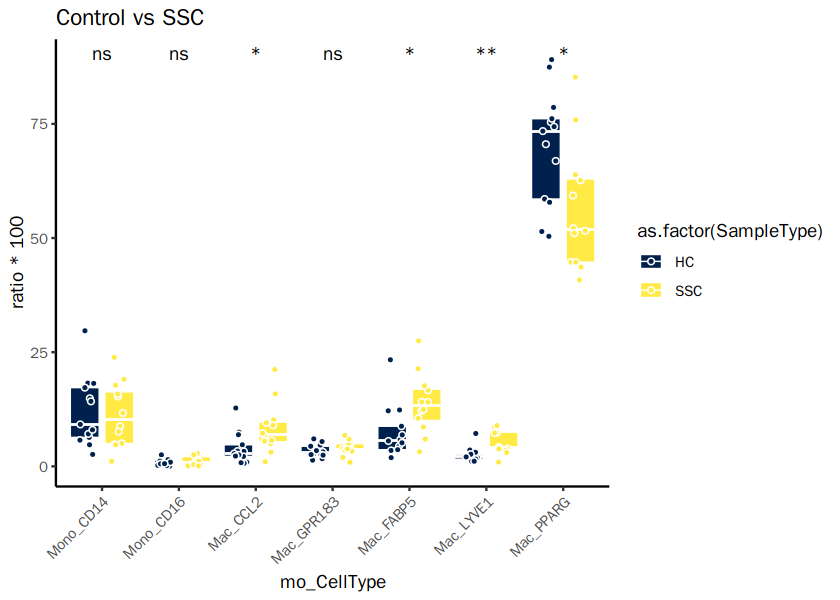

In [66]:
## 绘制 Control 和 SSC 样本中不同细胞类型的差异
# ssc <- readRDS("/share/home/qlab/projects/qlab_yrs/project_ssc/data/object/all/sam_df_anno_SSC.rds")
classifier  <- "Group"
metadata.df  <- immune@meta.data %>%
  tibble::rownames_to_column(var = "Cell")
cell_num.df  <- immune@meta.data %>%
  dplyr::group_by(SamNum, !!sym(classifier)) %>%
  dplyr::summarise(total = n()) %>%
  dplyr::ungroup() %>%
  dplyr::rename(SampleType = 2) %>%
  dplyr::mutate(ID = paste0(SamNum,".",SampleType)) %>%
  dplyr::select(ID,total)

ratio.df  <- metadata.df %>%
  dplyr::group_by(SamNum,!!sym(classifier), mo_CellType) %>% #
  dplyr::summarise(sum = n()) %>%
  ungroup() %>%
  dplyr::rename(SampleType = 2) %>%
  tidyr::complete(nesting(SamNum, SampleType), mo_CellType, fill = list(sum = 0)) %>% #
  dplyr::mutate(ID = paste0(SamNum,".",SampleType)) %>%
  left_join(cell_num.df, by = "ID") %>%
  rowwise() %>%
  dplyr::mutate(ratio = sum / total )

ratio.df$mo_CellType <- factor(ratio.df$mo_CellType, ct.order)
# colors.use  <- scales::viridis_pal()(3)[1:2]
colors.use  <- viridis(2, option = "E")
fig.size(5,7)
ggplot(ratio.df,aes(x = mo_CellType, y = ratio * 100, fill = as.factor(SampleType))) + #
  geom_boxplot(outlier.shape = NA, position=position_dodge(width=0.9), size = 0.3, colour = "#FFFFFF") +
  geom_point(pch = 21, position = position_jitterdodge(), colour = "white", size = 1.25) +
  #   geom_jitter( size = 0.6 , position=position_dodge(width=0.9),aes(group=SampleType, alpha = 0.6)) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ggtitle("Control vs SSC") +
  scale_fill_manual(values = colors.use)+ 
  stat_compare_means(aes(label = after_stat(p.signif)), label.x = 10, method = "t.test") 
# ggsave('./figures/CellProp_SSCvsHC.pdf', width = 5, heigh = 4)

Warning message:
“Removed 3502 rows containing non-finite outside the scale range (`stat_density()`).”
Warning message:
“Removed 35517 rows containing non-finite outside the scale range (`stat_density()`).”


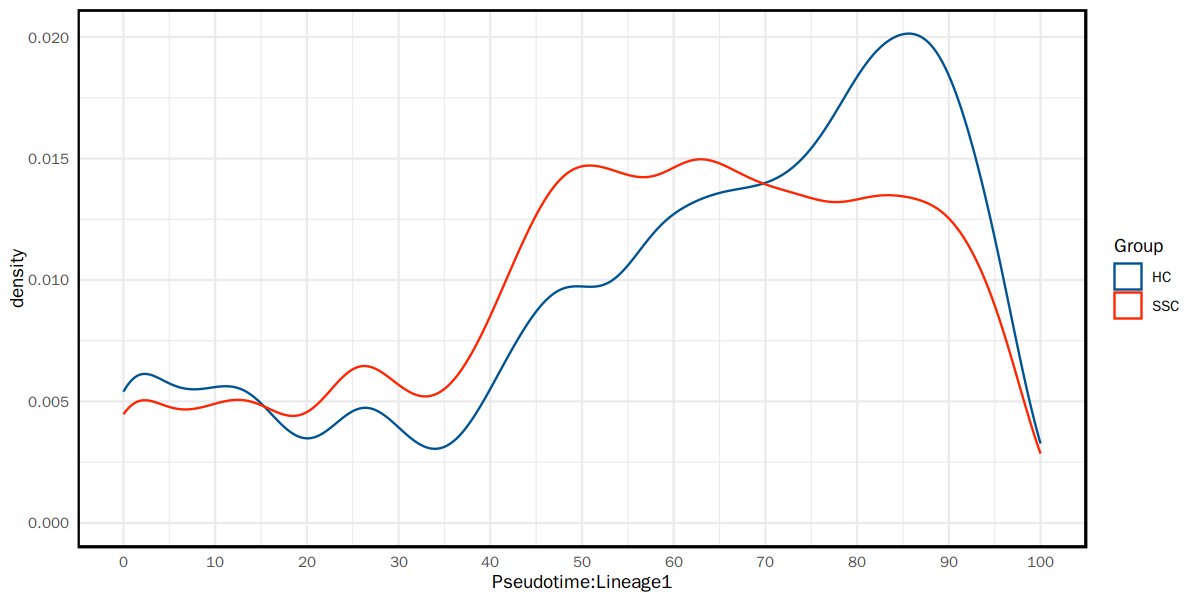

Warning message:
“Removed 37893 rows containing non-finite outside the scale range (`stat_density()`).”


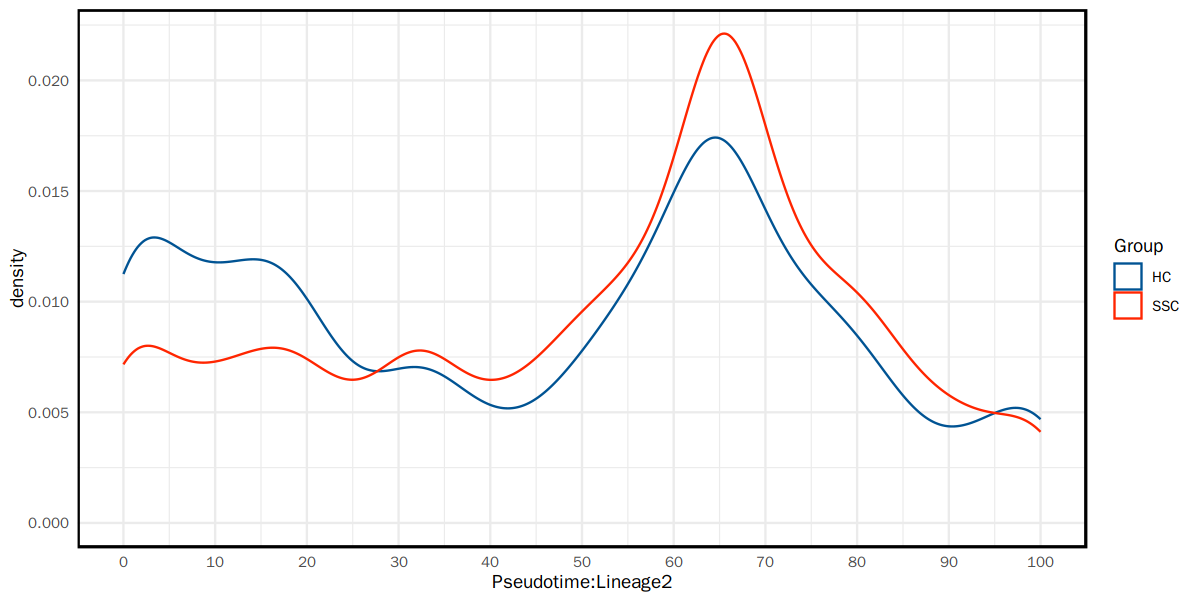

Warning message:
“Removed 50584 rows containing non-finite outside the scale range (`stat_density()`).”


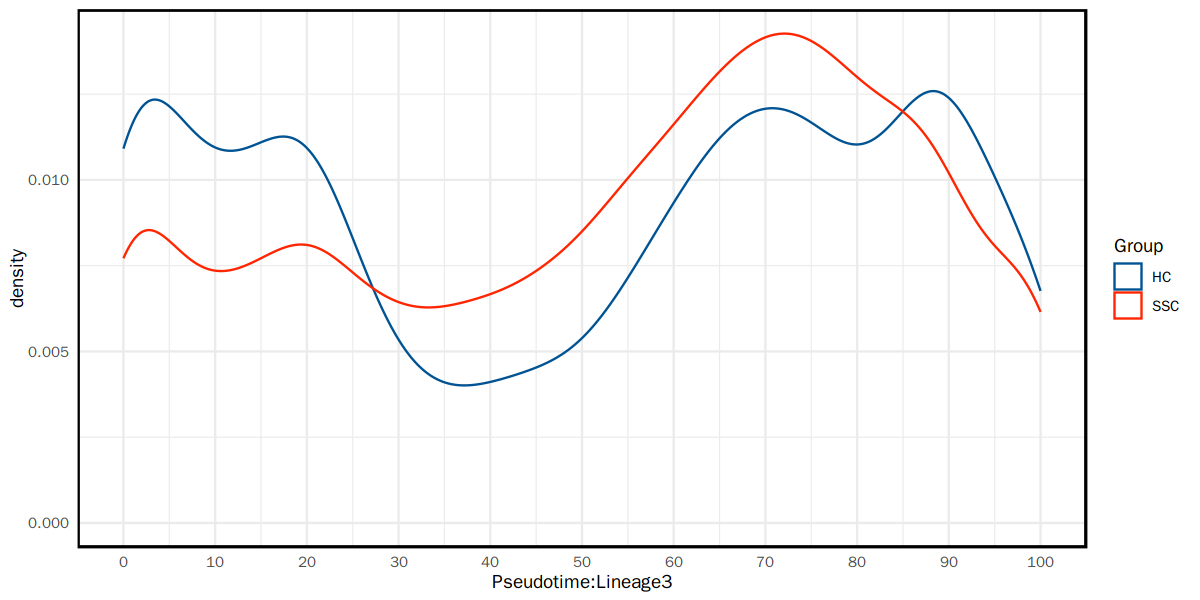

Warning message:
“Removed 3502 rows containing missing values or values outside the scale range (`geom_point()`).”


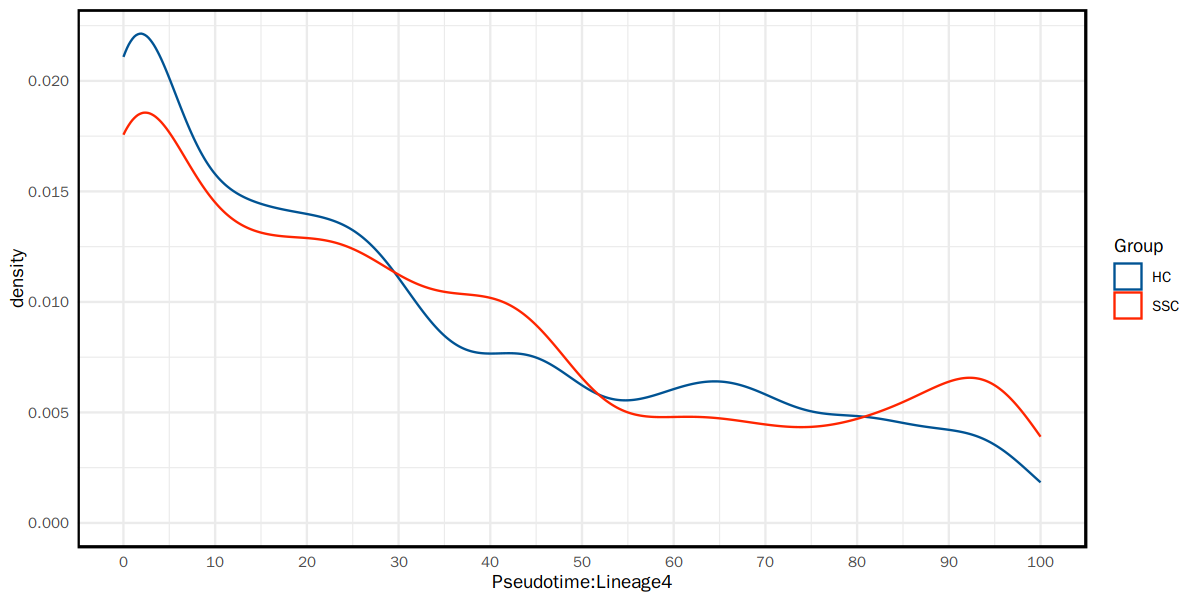

Warning message:
“Removed 3502 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 35517 rows containing missing values or values outside the scale range (`geom_point()`).”


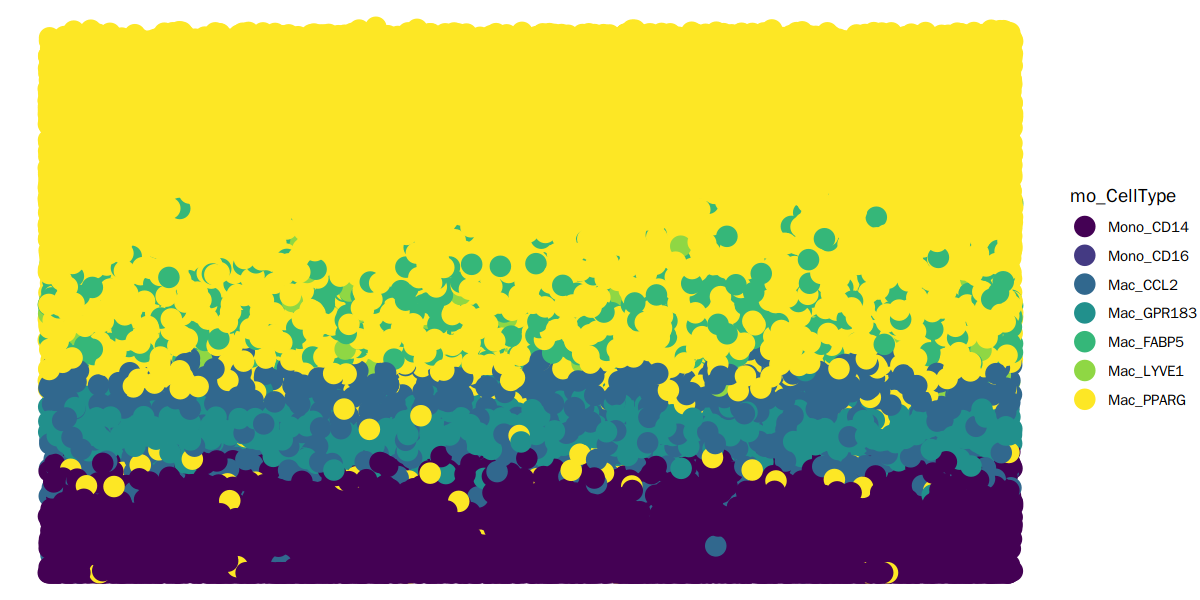

Warning message:
“Removed 35517 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 37893 rows containing missing values or values outside the scale range (`geom_point()`).”


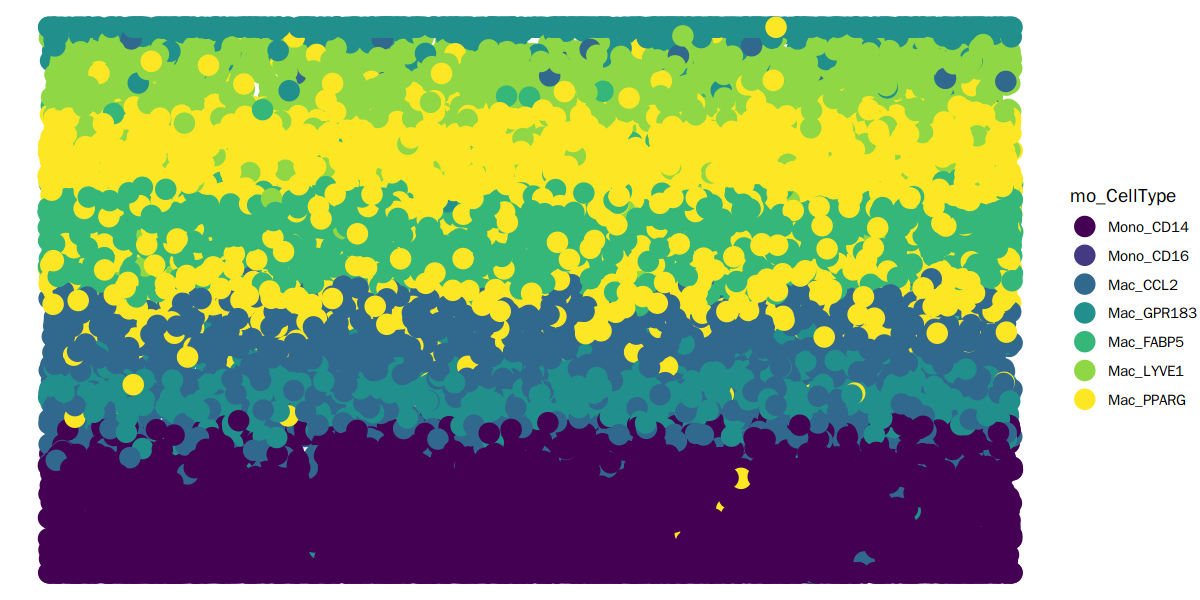

Warning message:
“Removed 37893 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 50584 rows containing missing values or values outside the scale range (`geom_point()`).”


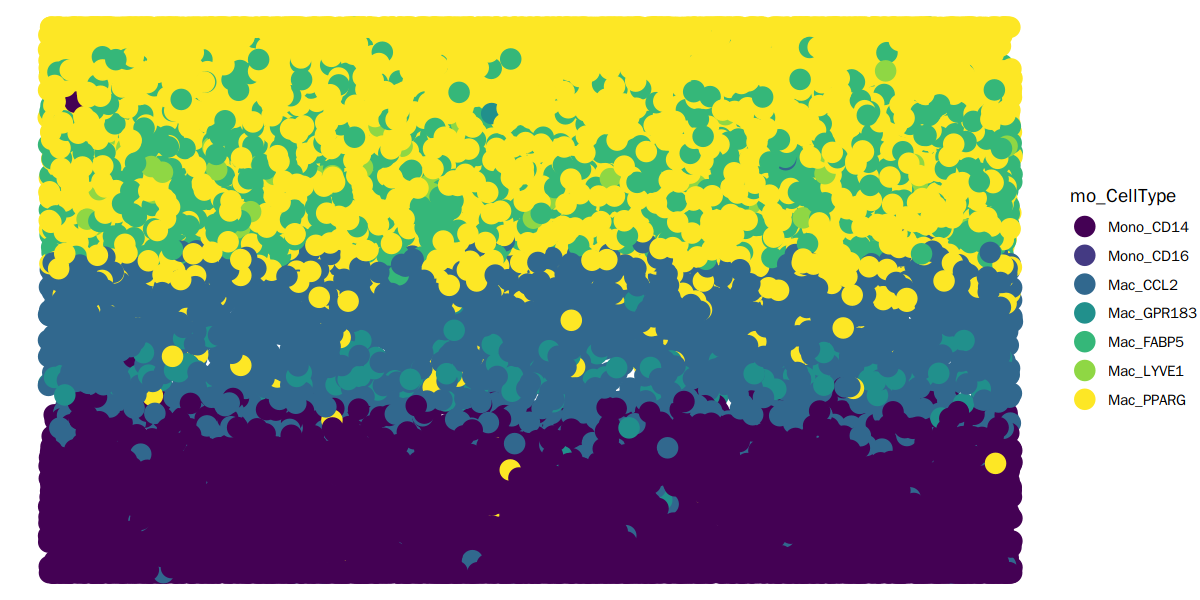

Warning message:
“Removed 50584 rows containing missing values or values outside the scale range (`geom_point()`).”


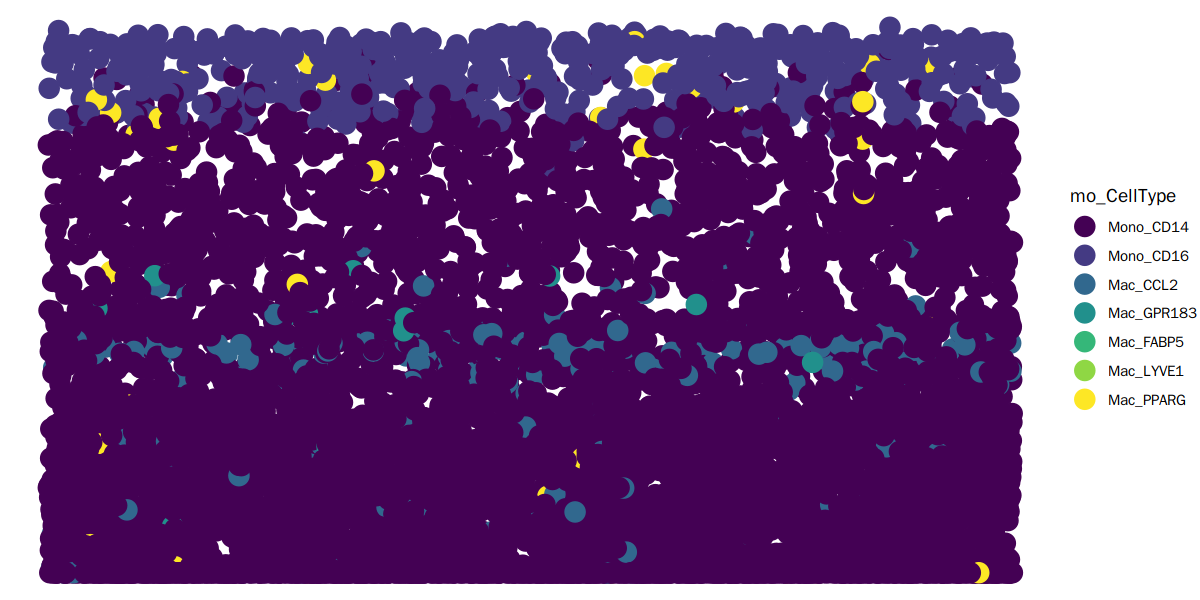

In [80]:
# --- Slingshot
meta.data <- immune@meta.data
colors.use  <- c("#005393","#ff2500")
for(cv in c("Lineage1","Lineage2","Lineage3","Lineage4"
           )) {
  cv_pct  <- paste0(cv,"_pct")
  # cv_pct_p<- paste0(cv,"_pct_p")
  # pdf(paste0("./",cv,"_treat_pct.pdf"))
  cv_pct_p <- ggplot(meta.data, aes(x = !!sym(cv_pct), color = Group)) + #sym 中是metadata里 curve那一列colnames的名字，color中是我们准备分的组的colnames
    geom_density() +
    #facet_wrap(~Group) +#～后面跟的是注释信息
    theme_minimal() +
    theme(panel.border = element_rect(colour = "black", fill=NA, size=1)) +
    #ylim(c(0,0.1)) +
    xlab(paste0("Pseudotime:",cv)) +
    scale_colour_manual(values = colors.use) +
    scale_x_continuous(breaks=seq(0, 100, 10)) 
  # ggsave(paste0("./figures/",cv,"_ss.pdf"), width = 4.25, heigh = 2)
    print(cv_pct_p)
    # dev.off() 
}
ggplot(immune@meta.data)+geom_point(mapping=aes(x=1, y=Lineage1_pct, color= mo_CellType), position='jitter', size = 5) +
scale_color_manual(values =  viridis(7, option = "D")) +
theme_void()
ggsave('./figures/l1_legend.pdf',width=3,heigh =15)
ggplot(immune@meta.data)+geom_point(mapping=aes(x=1,y=Lineage2_pct,colour= mo_CellType),position='jitter', size = 5) +
scale_color_manual(values = viridis(7, option = "D")) +
theme_void()
ggsave('./figures/l2_legend.pdf',width=3,heigh =15)
ggplot(immune@meta.data)+geom_point(mapping=aes(x=1,y=Lineage3_pct,colour= mo_CellType),position='jitter', size = 5) +
scale_color_manual(values = viridis(7, option = "D")) +
theme_void()
ggsave('./figures/l3_legend.pdf',width=3,heigh =15)
ggplot(immune@meta.data)+geom_point(mapping=aes(x=1,y=Lineage4_pct,colour= mo_CellType),position='jitter', size = 5) +
scale_color_manual(values = viridis(7, option = "D")) +
theme_void()
ggsave('./figures/l4_legend.pdf',width=3,heigh =15)

In [118]:
# library(tradeSeq)
# sce.l <- readRDS('./l1_tradeseq.rds')
# condRes1 <- conditionTest(sce.l, l2fc = log2(1.5))
# conditionGenes.1 <- rownames(condRes1)[condRes1$pvalue <= 0.05]
# conditionGenes.1 <- conditionGenes.1[!is.na(conditionGenes.1)] 
# conditionGenes.1
# plotSmoothers(sce.l, assays(sce.l)$counts, gene = conditionGenes.1[1],#curvesCols = curvesCols, 
#               alpha = 1, border = TRUE)
# data <- condRes1 %>% 
#             rownames_to_column(var='gene') %>% 
#             filter(pvalue < 0.05) %>% 
#             .[order(-.[,2]),] %>%
#             mutate(Rank_by_waldStat = 1:length(.[,2]))
# data$pvalue[which(data$pvalue == 0.000000e+00)] <- 1.0e-16
# data$gene[which(data$pvalue != 1.0e-16)] <- NA
# ggplot(data) + 
#     geom_point(mapping=aes(x = Rank_by_waldStat, y = waldStat, colour = (-log10(pvalue)))) + 
#     geom_text_repel(#data %>% filter(pvalue == 1.0e-16),
#         label=data$gene,x=data$Rank_by_waldStat, y = data$waldStat, max.overlaps = getOption("ggrepel.max.overlaps", default = 20)) +
#     scale_color_viridis(begin=1,end=0,option="A") +
#     theme_bw()
# ggsave('./figures/conRes1.pdf',width=8,heigh = 5)

# sce.l <- readRDS('./l2_tradeseq.rds')
# condRes1 <- conditionTest(sce.l, l2fc = log2(1.5))
# conditionGenes.1 <- rownames(condRes1)[condRes1$pvalue <= 0.05]
# conditionGenes.1 <- conditionGenes.1[!is.na(conditionGenes.1)] 
# conditionGenes.1
# plotSmoothers(sce.l, assays(sce.l)$counts, gene = conditionGenes.1[1],#curvesCols = curvesCols, 
#               alpha = 1, border = TRUE)
# data <- condRes1 %>% 
#             rownames_to_column(var='gene') %>% 
#             filter(pvalue < 0.05) %>% 
#             .[order(-.[,2]),] %>%
#             mutate(Rank_by_waldStat = 1:length(.[,2]))
# data$pvalue[which(data$pvalue == 0.000000e+00)] <- 1.0e-16
# data$gene[which(data$pvalue != 1.0e-16)] <- NA
# ggplot(data) + 
#     geom_point(mapping=aes(x = Rank_by_waldStat, y = waldStat, colour = (-log10(pvalue)))) + 
#     geom_text_repel(#data %>% filter(pvalue == 1.0e-16),
#         label=data$gene,x=data$Rank_by_waldStat, y = data$waldStat, max.overlaps = getOption("ggrepel.max.overlaps", default = 20)) +
#     scale_color_viridis(begin=1,end=0,option="A") +
#     theme_bw()
# ggsave('./figures/conRes2.pdf',width=8,heigh = 5)

# sce.l <- readRDS('./l3_tradeseq.rds')
# condRes1 <- conditionTest(sce.l, l2fc = log2(1.5))
# conditionGenes.1 <- rownames(condRes1)[condRes1$pvalue <= 0.05]
# conditionGenes.1 <- conditionGenes.1[!is.na(conditionGenes.1)] 
# conditionGenes.1
# plotSmoothers(sce.l, assays(sce.l)$counts, gene = conditionGenes.1[1],#curvesCols = curvesCols, 
#               alpha = 1, border = TRUE)
# data <- condRes1 %>% 
#             rownames_to_column(var='gene') %>% 
#             filter(pvalue < 0.05) %>% 
#             .[order(-.[,2]),] %>%
#             mutate(Rank_by_waldStat = 1:length(.[,2]))
# data$pvalue[which(data$pvalue == 0.000000e+00)] <- 1.0e-16
# data$gene[which(data$pvalue != 1.0e-16)] <- NA
# ggplot(data) + 
#     geom_point(mapping=aes(x = Rank_by_waldStat, y = waldStat, colour = (-log10(pvalue)))) + 
#     geom_text_repel(#data %>% filter(pvalue == 1.0e-16),
#         label=data$gene,x=data$Rank_by_waldStat, y = data$waldStat, max.overlaps = getOption("ggrepel.max.overlaps", default = 20)) +
#     scale_color_viridis(begin=1,end=0,option="A") +
#     theme_bw()
# ggsave('./figures/conRes3.pdf',width=8,heigh = 5)

# sce.l <- readRDS('./l4_tradeseq.rds')
# condRes1 <- conditionTest(sce.l, l2fc = log2(1.5))
# conditionGenes.1 <- rownames(condRes1)[condRes1$pvalue <= 0.05]
# conditionGenes.1 <- conditionGenes.1[!is.na(conditionGenes.1)] 
# conditionGenes.1
# plotSmoothers(sce.l, assays(sce.l)$counts, gene = conditionGenes.1[1],#curvesCols = curvesCols, 
#               alpha = 1, border = TRUE)
# data <- condRes1 %>% 
#             rownames_to_column(var='gene') %>% 
#             filter(pvalue < 0.05) %>% 
#             .[order(-.[,2]),] %>%
#             mutate(Rank_by_waldStat = 1:length(.[,2]))
# data$pvalue[which(data$pvalue == 0.000000e+00)] <- 1.0e-16
# data$gene[which(data$pvalue != 1.0e-16)] <- NA
# ggplot(data) + 
#     geom_point(mapping=aes(x = Rank_by_waldStat, y = waldStat, colour = (-log10(pvalue)))) + 
#     geom_text_repel(#data %>% filter(pvalue == 1.0e-16),
#         label=data$gene,x=data$Rank_by_waldStat, y = data$waldStat, max.overlaps = getOption("ggrepel.max.overlaps", default = 20)) +
#     scale_color_viridis(begin=1,end=0,option="A") +
#     theme_bw()
# ggsave('./figures/conRes4.pdf',width=8,heigh = 5)

In [6]:
# # --- Arrange TradeSeq Genes
# library(tradeSeq)
# library(RColorBrewer)
# library(SingleCellExperiment)
# library(magrittr)
# library(slingshot)
# library(mclust, quietly = TRUE)
# library(mgcv)
# sce1 <- readRDS('l1_tradeseq.rds')
# condRes1 <- conditionTest(sce1, l2fc = log2(1.5))
# data <- condRes1 %>% rownames_to_column(var='gene')
# data <- filter(data, pvalue < 0.05) 
# data$pvalue[which(data$pvalue == 0.000000e+00)] <- 1.0e-16
# data <- data[order(-data[,2]),]
# data$`Rank_by_waldStat` <- 1:length(data[,2])
# data.l1 <- data %>% mutate(Lineage = 'L1:Mac_PPARG')

# sce1 <- readRDS('l2_tradeseq.rds')
# condRes1 <- conditionTest(sce1, l2fc = log2(1.5))
# data <- condRes1 %>% rownames_to_column(var='gene')
# data <- filter(data, pvalue < 0.05) 
# data$pvalue[which(data$pvalue == 0.000000e+00)] <- 1.0e-16
# data <- data[order(-data[,2]),]
# data$`Rank_by_waldStat` <- 1:length(data[,2])
# data.l2 <- data %>% mutate(Lineage = 'L2:Mac_SPP1')

# sce1 <- readRDS('l3_tradeseq.rds')
# condRes1 <- conditionTest(sce1, l2fc = log2(1.5))
# data <- condRes1 %>% rownames_to_column(var='gene')
# data <- filter(data, pvalue < 0.05) 
# data$pvalue[which(data$pvalue == 0.000000e+00)] <- 1.0e-16
# data <- data[order(-data[,2]),]
# data$`Rank_by_waldStat` <- 1:length(data[,2])
# data.l3 <- data %>% mutate(Lineage = 'L3:Mac_LYVE1')

# sce1 <- readRDS('l4_tradeseq.rds')
# condRes1 <- conditionTest(sce1, l2fc = log2(1.5))
# data <- condRes1 %>% rownames_to_column(var='gene')
# data <- filter(data, pvalue < 0.05) 
# data$pvalue[which(data$pvalue == 0.000000e+00)] <- 1.0e-16
# data <- data[order(-data[,2]),]
# data$`Rank_by_waldStat` <- 1:length(data[,2])
# data.l4 <- data %>% mutate(Lineage = 'L4:Mono_CD16')

# rbind(data.l1, data.l2) %>% rbind(data.l3) %>% rbind(data.l4) %>%
# write.csv('Figure5.hk.csv')

In [25]:
# --- change monocle metadata
# library(monocle3)
# library(S4Vectors)
# cds <- readRDS('./monocle1.rds')
# --- 对 monocle中的细胞类型进行重新命名
# colData(cds)$mo_CellType <- dplyr::recode(colData(cds)$mo_CellType,
#                                                 'Alveolar_mac'='Alveolar_mac',
#                                                  'mono_derive_4'='CCL18_mono',
#                                                  'CD14_mono'='CD14_mono',
#                                                  'mono_derive_1'='CXCL8_mono',
#                                                  'mono_derive_2'='GPR183_mono',
#                                                  'mono_derive_3'='FOLR2_mono',
#                                                  'CD16_mono'='CD16_mono')
# meta <- left_join(
#             immune@meta.data %>% rownames_to_column(var = 'barcode') %>% .[, 1:38],
#             colData(cds) %>% as.data.frame() %>% rownames_to_column(var = 'barcode') %>% .[,c('barcode', 'Size_Factor')],
#             by = 'barcode') %>% column_to_rownames(var = 'barcode') %>% DataFrame()
# colData(cds) <- meta
# saveRDS(cds, 'monocle.rds')

In [30]:
library(monocle3)
# cds <- readRDS('./monocle.rds')
# cds@colData@listData$mo_CellType <- factor(cds@colData@listData$mo_CellType, levels = ct.order)

options(repr.plot.height = 5, repr.plot.width = 7)
pdf('./figures/monocle.pdf', height = 5, width = 7)
plot_cells(
  cds,
  x = 1,
  y = 2,
  reduction_method = "UMAP",
  color_cells_by = "mo_CellType",
  # group_cells_by = "CellType",
  genes = NULL,
  show_trajectory_graph = TRUE,
  trajectory_graph_color = "black",
  trajectory_graph_segment_size = 0.75,
  norm_method = c("log", "size_only"),
  label_cell_groups = FALSE, #TRUE:在图上标注出各个细胞群的名字，FALSE：以图例的形式标注出细胞群的名字。
  label_groups_by_cluster = TRUE, #是否将细胞群的名字标注在每个细胞群落的中心
  group_label_size = 1, #细胞群落名字的标签大小
  labels_per_group = 1,
  label_branch_points = FALSE,#标注出每一个节点的编号：黑色的圆圈显示
  label_roots = FALSE,#标注出每一个根的标号
  label_leaves = FALSE,#标注出每一个细胞群的编号，灰色的圆圈显示
  graph_label_size = 3,#标注的大小
  cell_size = 0.5,
  # cell_stroke = I(cell_size/2),
  alpha = 0.8,
  min_expr = 0.1,
  rasterize = FALSE,
  scale_to_range = TRUE,
  label_principal_points = TRUE #标注出分支的名字，方便后续选取分支进行深入分析
)+
scale_colour_manual(values = viridis(7, option = "D"))
dev.off()

Warning message:
“ggrepel: 41 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


png 
  2

In [4]:
pseudotime <- readRDS('./Rectome_all_assays_samples.rds')
metadata <- pseudotime@meta.data %>% tibble::rownames_to_column(var='Cell') %>% 
                .[,c('Cell','Group','Lineage1_pct','Lineage2_pct','Lineage3_pct','Lineage4_pct')]

Joining, by = "Cell"
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
“Removed 509984 rows containing non-finite values (stat_smooth).”
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
“Removed 509984 rows containing non-finite values (stat_smooth).”


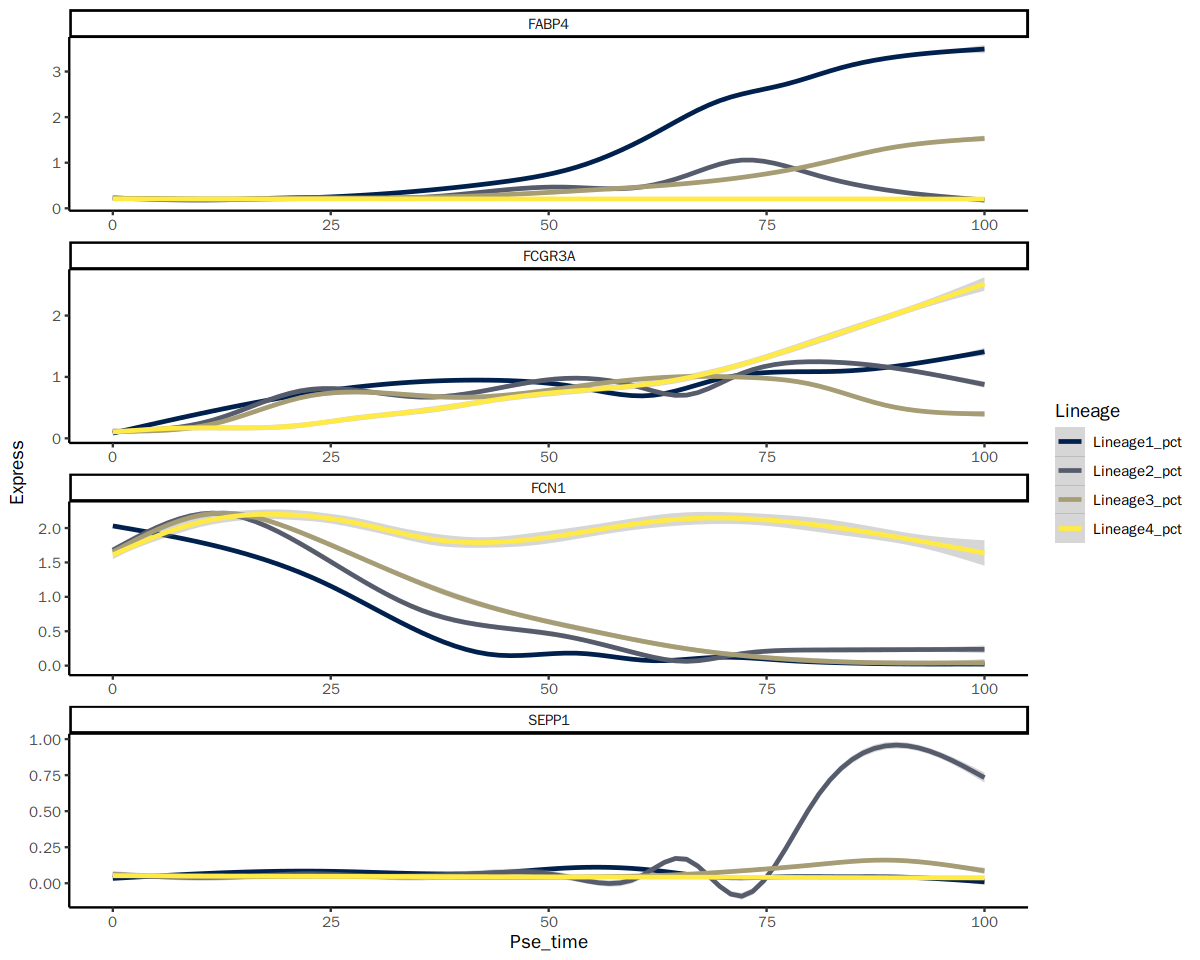

In [81]:
genes <- c('FCN1','FCGR3A','FABP4','SEPP1') 
# 保留：'FCN1'：monocyte
    #  'FCGR3A'： CD16
    #  'FABP4'：Ave_Mac
    # 'SEPP1‘：M2
gene.seurat <- pseudotime[['RNA']]@data[genes,] %>% as.matrix() %>%
                                        t() %>% as.data.frame() %>% 
                                        tibble::rownames_to_column(var='Cell') %>%
                                        left_join(metadata, var='Cell')

data.seurat <- gene.seurat %>% 
    pivot_longer(!c(Cell,FCN1,FCGR3A,FABP4,SEPP1,Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
    pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

ggplot(data = data.seurat, aes(x=Pse_time, y=Express, group = Lineage, color=Lineage))+ 
  geom_smooth()+
  scale_colour_manual(values = viridis(4, option = "E"))+
  theme_classic()+
  facet_wrap(~Gene, nrow=6, scales = 'free')
ggsave('./figures/RNA.pdf', width = 5, height = 10)

In [ ]:
tfs <- c('RUNX3','NFKB1','TWIST1','PPARG')
# 'RUNX3','NFKB1',
# 'PPARG'：mac
# 'TWIST1': 这个把细胞类型条拉一下，看下能不能说明什么问题，这个tf因子是tgf-b的

tfs.seurat <- pseudotime[['TF']]@data[tfs,] %>% 
                t() %>% 
                as.data.frame() %>% 
                tibble::rownames_to_column(var='Cell') %>%
                left_join(metadata, var='Cell')

data.seurat <- tfs.seurat %>% 
    pivot_longer(!c(Cell,RUNX3,NFKB1,TWIST1,PPARG,Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
    pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

ggplot(data = data.seurat.t2, aes(x=Pse_time, y=Express, group = Lineage, color=Lineage))+ 
  geom_smooth()+
  scale_colour_manual(values = viridis(4, option = "E"))+
  theme_classic()+
  facet_wrap(~Gene, nrow=6, scales = 'free')
ggsave('./figures/TF.pdf', width = 5, height = 10)

Joining, by = "Cell"
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
“Removed 509984 rows containing non-finite values (stat_smooth).”
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
“Removed 509984 rows containing non-finite values (stat_smooth).”


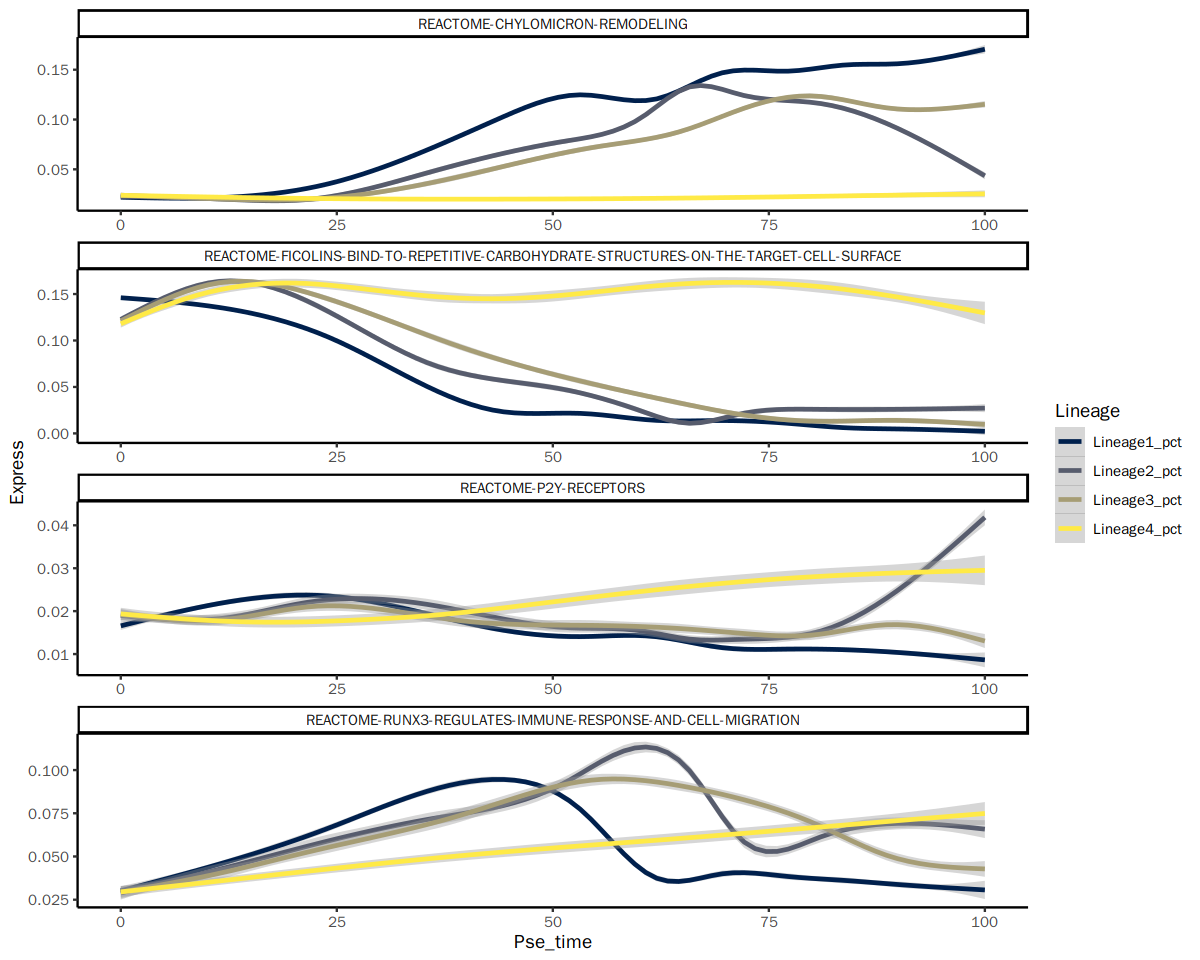

In [83]:
auc <- c('REACTOME-RUNX3-REGULATES-IMMUNE-RESPONSE-AND-CELL-MIGRATION',
    'REACTOME-P2Y-RECEPTORS',
    'REACTOME-CHYLOMICRON-REMODELING',
    'REACTOME-FICOLINS-BIND-TO-REPETITIVE-CARBOHYDRATE-STRUCTURES-ON-THE-TARGET-CELL-SURFACE'
)
# 'REACTOME-RUNX3-REGULATES-IMMUNE-RESPONSE-AND-CELL-MIGRATION',与SSC，monocyte有些关系
# 'REACTOME-P2Y-RECEPTORS',
# 'REACTOME-CHYLOMICRON-REMODELING',巨噬细胞
# 'REACTOME-FICOLINS-BIND-TO-REPETITIVE-CARBOHYDRATE-STRUCTURES-ON-THE-TARGET-CELL-SURFACE',

auc.seurat <- pseudotime[['AUC']]@data[auc,] %>% 
                t() %>% 
                as.data.frame() %>% 
                tibble::rownames_to_column(var='Cell') %>%
                left_join(metadata, var='Cell')

data.seurat <- auc.seurat %>% 
    pivot_longer(!c(Cell,
                    'REACTOME-RUNX3-REGULATES-IMMUNE-RESPONSE-AND-CELL-MIGRATION',
                    'REACTOME-P2Y-RECEPTORS',
                    'REACTOME-CHYLOMICRON-REMODELING',
                    'REACTOME-FICOLINS-BIND-TO-REPETITIVE-CARBOHYDRATE-STRUCTURES-ON-THE-TARGET-CELL-SURFACE', 
                    Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
    pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

ggplot(data = data.seurat, aes(x=Pse_time, y=Express, group = Lineage, color=Lineage))+ 
  geom_smooth()+
  scale_colour_manual(values = viridis(4, option = "E"))+
  theme_classic()+
  facet_wrap(~Gene, nrow=6, scales = 'free')
ggsave('./figures/AUC.pdf', width = 8, height = 10)

In [15]:
# Lineage1:RNA, TFs, AUCs.
pseu.l <- subset(pseudotime, Lineage1 != 'NA')
metadata <- pseu.l@meta.data %>% tibble::rownames_to_column(var='Cell') %>% 
                .[,c('Cell','Group','Lineage1_pct')]

In [103]:
# # 这个cells 里面是用不同的线条类型（linetype）把 SSC和 HC进行一个区分
# genes <- c('CCL2','APOE','CXCL8','HPGD','MT1E','INHBA')
# gene.seurat <- pseudotime[['RNA']]@data[genes,] %>% 
#                                     as.matrix() %>%
#                                     t() %>% 
#                                     as.data.frame() %>% 
#                                     tibble::rownames_to_column(var='Cell') %>% 
#                                     left_join(metadata, var='Cell')  %>% 
#                                     pivot_longer(!c(Cell,'CCL2','APOE','CXCL8','HPGD','MT1E','INHBA',Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
#                                     pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')


# ggplot(data = gene.seurat, aes(x=Pse_time, y=Express, group = Group, color=Group, linetype = Group))+ 
#   geom_smooth()+
#   scale_colour_manual(values = c('black','black'))+
#   theme_classic()+
#   facet_wrap(~Gene, nrow=6, scales = 'free')
# ggsave('./figures/L1_RNA.pdf',width = 5, height = 10)

Joining, by = "Cell"
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



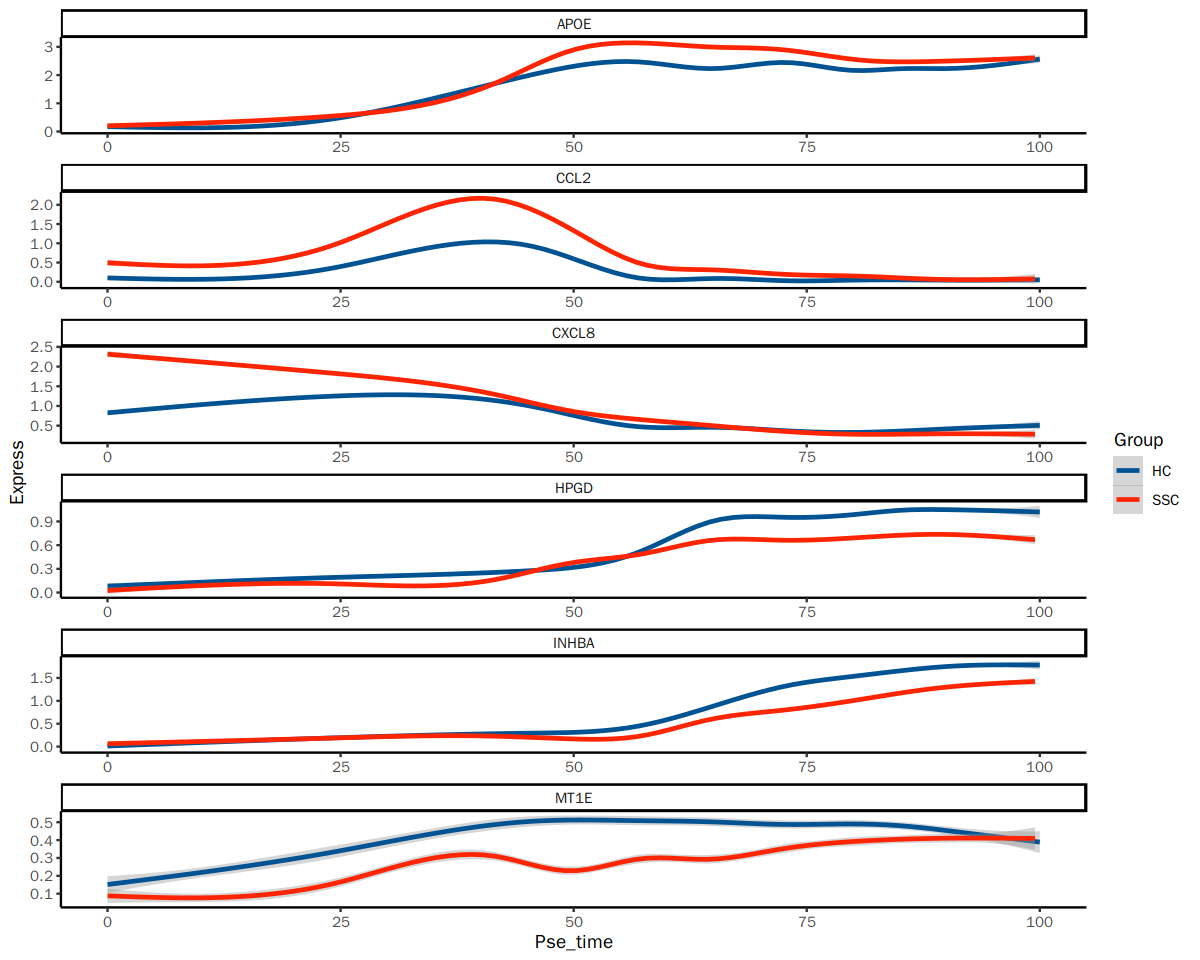

In [157]:
genes <- c('CCL2','APOE','CXCL8','HPGD','MT1E','INHBA')
# 'CCL2',
# 'APOE',
# 'CXCL8',
# 'HPGD', 抑制炎症
# 'MT1E', MT1E is a potential tumour suppressor gene, whose loss may promote resistance to apoptosis-inducing therapies.
# 'INHBA'tgf-b
gene.seurat <- pseu.l[['RNA']]@data[genes,] %>% 
                                    as.matrix() %>%
                                    t() %>% 
                                    as.data.frame() %>% 
                                    tibble::rownames_to_column(var='Cell') %>% 
                                    left_join(metadata, var='Cell')  %>% 
                                    pivot_longer(!c(Cell,'CCL2','APOE','CXCL8','HPGD','MT1E','INHBA',Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
                                    pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')


ggplot(data = gene.seurat, aes(x=Pse_time, y=Express, group = Group, color=Group))+ 
  geom_smooth()+
  scale_colour_manual(values = c("#005393","#ff2500"))+
  theme_classic()+
  facet_wrap(~Gene, nrow=6, scales = 'free')
ggsave('./figures/L1_RNA.pdf',width = 5, height = 15)

Joining, by = "Cell"
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
“Removed 1942 rows containing non-finite values (stat_smooth).”
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
“Removed 1942 rows containing non-finite values (stat_smooth).”


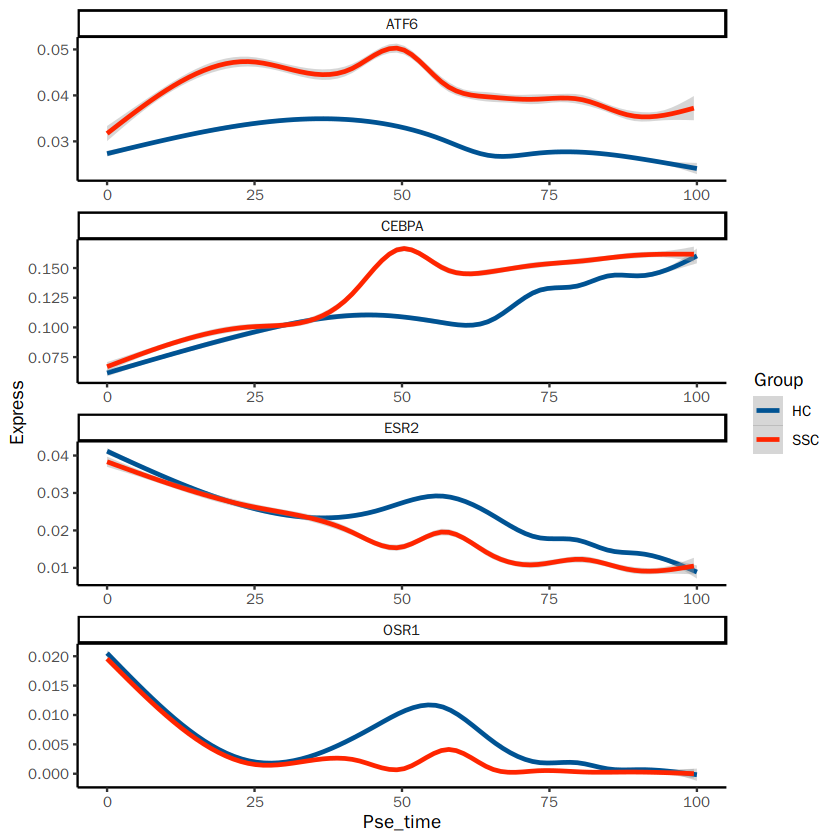

In [12]:
tfs <- c(
'OSR1',   # a novel tumor suppressor gene [DOI: 10.1038/s41374-020-00493-2]
'ATF6', #ER stress, ER stress 与炎症、氧化应激相关【doi: 10.1016/j.jcmgh.2017.11.016】
'CEBPA', # C/EBPα is required for macrophage functions, which plays an important role in maintaining skeletal muscle energy metabolism.【DOI: 10.1152/ajpendo.00002.2014】
'ESR2') # normally expressed in macrophage []


tf.seurat <- pseu.l[['TF']]@data[tfs,] %>% 
                                    as.matrix() %>%
                                    t() %>% 
                                    as.data.frame() %>% 
                                    tibble::rownames_to_column(var='Cell') %>% 
                                    left_join(metadata, var='Cell') %>% 
                                    pivot_longer(!c(Cell,'OSR1','ATF6','CEBPA','ESR2'
                                                    ,Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
                                    pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

# colnames(tf.seurat) <- gsub('[-]', '_', colnames(tf.seurat))
# tfs <- gsub('[-]', '_', tfs)
ggplot(data = tf.seurat, aes(x=Pse_time, y=Express, group = Group, color=Group))+ 
  geom_smooth()+
  scale_colour_manual(values = c("#005393","#ff2500"))+
  theme_classic()+
  facet_wrap(~Gene, nrow=6, scales = 'free')
ggsave('./figures/L1_TF.pdf',width = 5, height = 15)

Joining, by = "Cell"
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



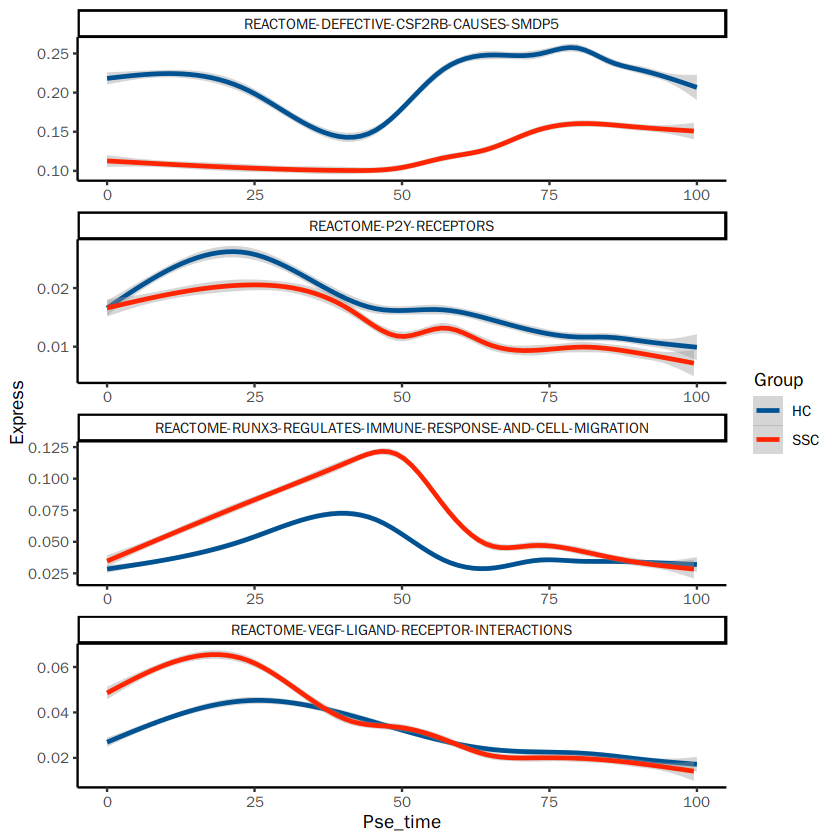

In [16]:
auc <- c(
    'REACTOME-RUNX3-REGULATES-IMMUNE-RESPONSE-AND-CELL-MIGRATION',
    'REACTOME-VEGF-LIGAND-RECEPTOR-INTERACTIONS',# 缺氧相关; 与tgf-b信号有关
    'REACTOME-P2Y-RECEPTORS', # #DOI: 10.1371/journal.p
        
        
        
        one.0111385，促炎
    # 'REACTOME-DISEASES-ASSOCIATED-WITH-SURFACTANT-METABOLISM',
    'REACTOME-DEFECTIVE-CSF2RB-CAUSES-SMDP5'# https://reactome.org/content/detail/R-HSA-5688849#:~:text=Defects%20in%20human%20CSF2RB%20can%20cause%20pulmonary%20surfactant,
                                            # %28Greenhill%20%26%20Kotton%202009%2C%20Whitsett%20et%20al.%202015%29.
)

auc.seurat <- pseu.l[['AUC']]@data[auc,] %>% 
                                    as.matrix() %>%
                                    t() %>% 
                                    as.data.frame() %>% 
                                    tibble::rownames_to_column(var='Cell') %>% 
                                    left_join(metadata, var='Cell') %>% 
                                    pivot_longer(!c(Cell,   
                                                        'REACTOME-RUNX3-REGULATES-IMMUNE-RESPONSE-AND-CELL-MIGRATION',
                                                        'REACTOME-VEGF-LIGAND-RECEPTOR-INTERACTIONS',# 缺氧相关
                                                        'REACTOME-P2Y-RECEPTORS',
                                                        # 'REACTOME-DISEASES-ASSOCIATED-WITH-SURFACTANT-METABOLISM',
                                                        'REACTOME-DEFECTIVE-CSF2RB-CAUSES-SMDP5',
                                                    Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
                                    pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

# colnames(auc.seurat) <- gsub('[-]', '_', colnames(auc.seurat))
# auc <- gsub('[-]', '_', auc)
ggplot(data = auc.seurat, aes(x=Pse_time, y=Express, group = Group, color=Group))+ 
  geom_smooth()+
  scale_colour_manual(values = c("#005393","#ff2500"))+
  theme_classic()+
  facet_wrap(~Gene, nrow=6, scales = 'free')
# ggsave('./figures/L1_AUC.pdf',width = 8, height = 15)

In [178]:
# Lineage2:RNA, TFs, AUCs.
pseu.l <- subset(pseudotime, Lineage2 != 'NA')
metadata <- pseu.l@meta.data %>% tibble::rownames_to_column(var='Cell') %>% 
                .[,c('Cell','Group','Lineage2_pct')]

Joining, by = "Cell"
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



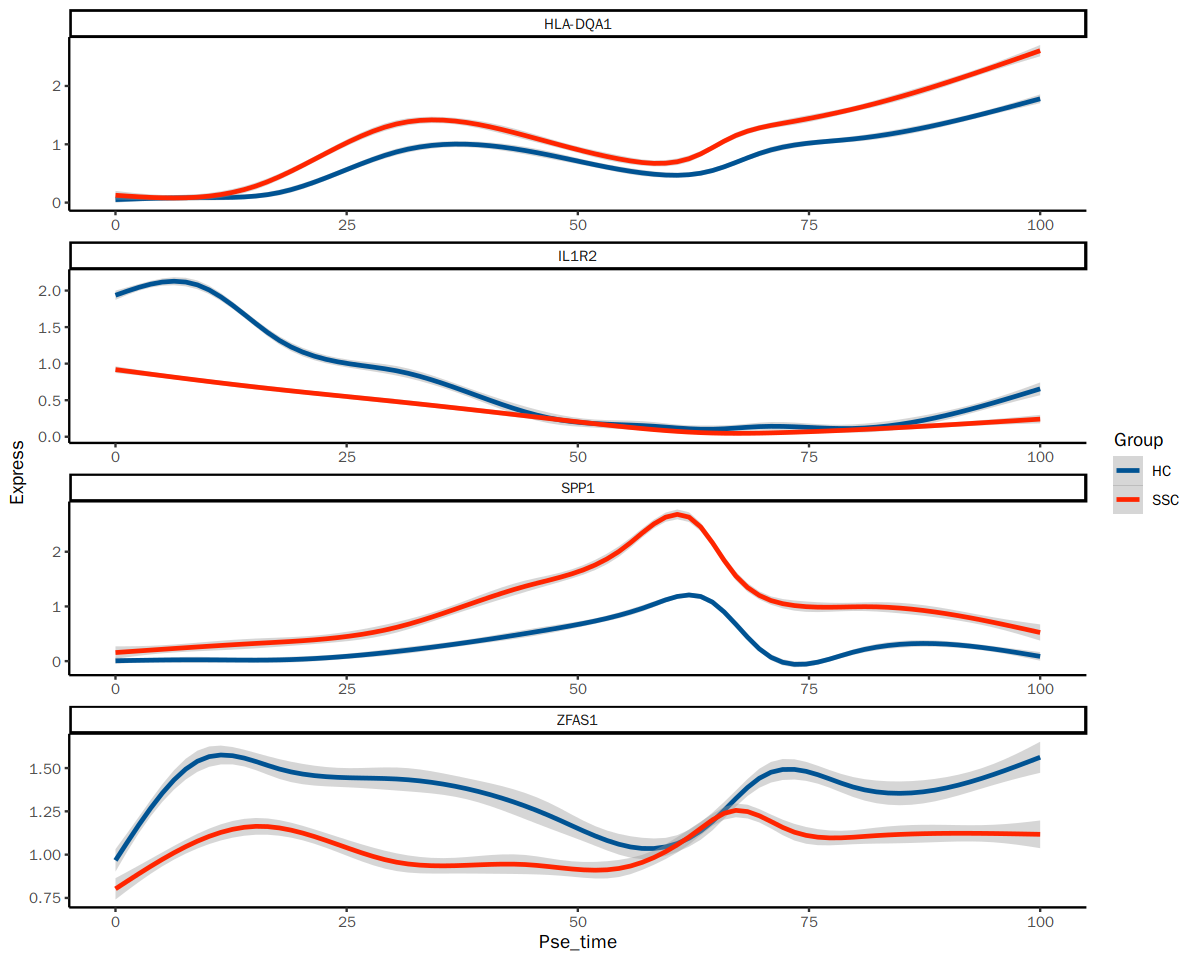

In [166]:
genes <- c('SPP1','HLA-DQA1','ZFAS1','IL1R2')
gene.seurat <- pseu.l[['RNA']]@data[genes,] %>% 
                                    as.matrix() %>%
                                    t() %>% 
                                    as.data.frame() %>% 
                                    tibble::rownames_to_column(var='Cell') %>% 
                                    left_join(metadata, var='Cell')  %>% 
                                    pivot_longer(!c(Cell,'SPP1','HLA-DQA1','ZFAS1','IL1R2',Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
                                    pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')


ggplot(data = gene.seurat, aes(x=Pse_time, y=Express, group = Group, color=Group))+ 
  geom_smooth()+
  scale_colour_manual(values = c("#005393","#ff2500"))+
  theme_classic()+
  facet_wrap(~Gene, nrow=6, scales = 'free')
ggsave('./figures/L2_RNA.pdf',width = 5, height = 12)

Joining, by = "Cell"
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



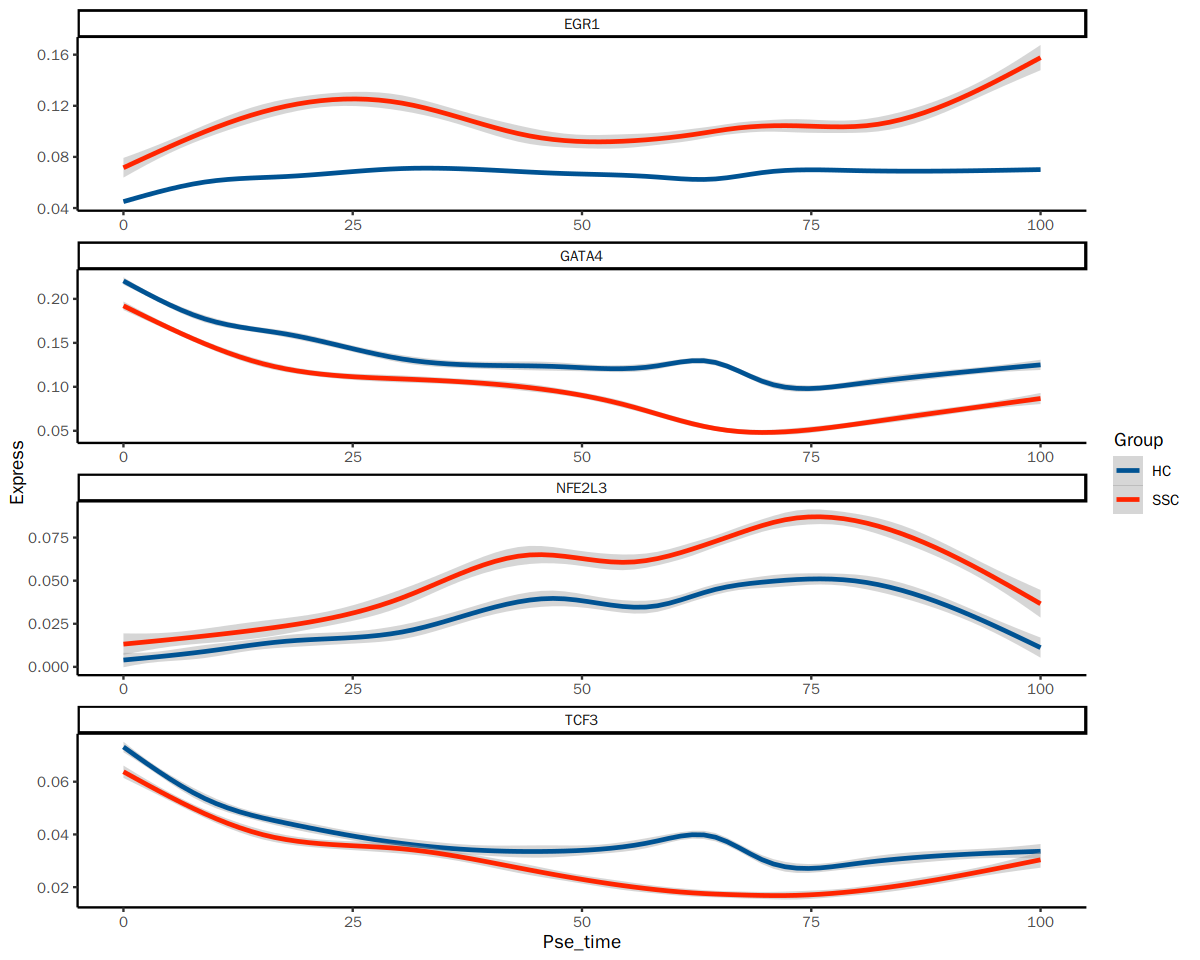

In [184]:
tfs <- c('NFE2L3','EGR1','GATA4','TCF3')
tf.seurat <- pseu.l[['TF']]@data[tfs,] %>% 
                                    as.matrix() %>%
                                    t() %>% 
                                    as.data.frame() %>% 
                                    tibble::rownames_to_column(var='Cell') %>% 
                                    left_join(metadata, var='Cell') %>% 
                                    pivot_longer(!c(Cell,'NFE2L3','EGR1','GATA4','TCF3',Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
                                    pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

# colnames(tf.seurat) <- gsub('[-]', '_', colnames(tf.seurat))
# tfs <- gsub('[-]', '_', tfs)
ggplot(data = tf.seurat, aes(x=Pse_time, y=Express, group = Group, color=Group))+ 
  geom_smooth()+
  scale_colour_manual(values = c("#005393","#ff2500"))+
  theme_classic()+
  facet_wrap(~Gene, nrow=6, scales = 'free')
ggsave('./figures/L2_TF.pdf',width = 5, height = 12)

Joining, by = "Cell"
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



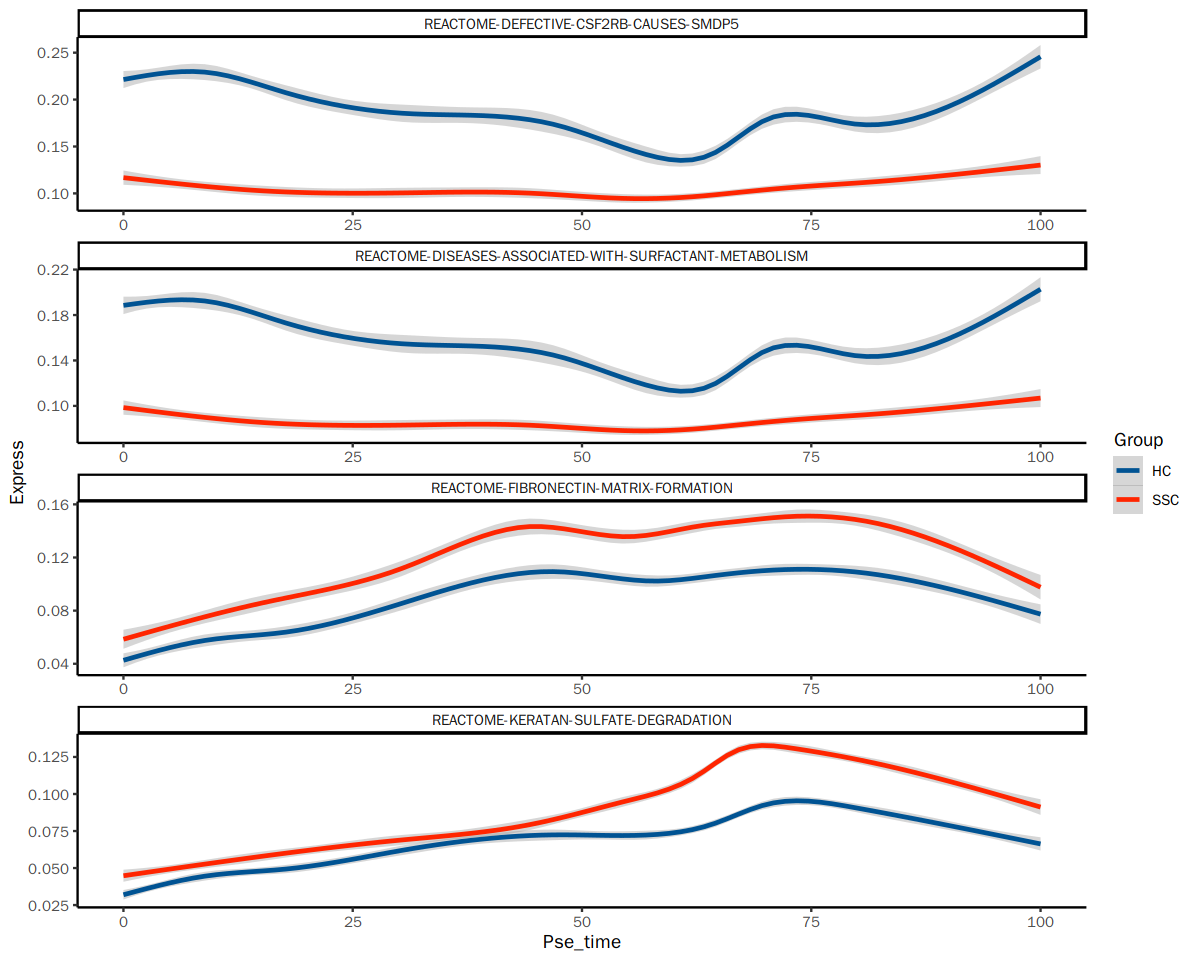

In [169]:
auc <- c(
    'REACTOME-KERATAN-SULFATE-DEGRADATION',
                                                    'REACTOME-FIBRONECTIN-MATRIX-FORMATION',
                                                   'REACTOME-DISEASES-ASSOCIATED-WITH-SURFACTANT-METABOLISM',
                                                    'REACTOME-DEFECTIVE-CSF2RB-CAUSES-SMDP5')
auc.seurat <- pseu.l[['AUC']]@data[auc,] %>% 
                                    as.matrix() %>%
                                    t() %>% 
                                    as.data.frame() %>% 
                                    tibble::rownames_to_column(var='Cell') %>% 
                                    left_join(metadata, var='Cell') %>% 
                                    pivot_longer(!c(Cell,   
                                                       'REACTOME-KERATAN-SULFATE-DEGRADATION',
                                                    'REACTOME-FIBRONECTIN-MATRIX-FORMATION',
                                                   'REACTOME-DISEASES-ASSOCIATED-WITH-SURFACTANT-METABOLISM',
                                                    'REACTOME-DEFECTIVE-CSF2RB-CAUSES-SMDP5',
                                                    Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
                                    pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

colnames(auc.seurat) <- gsub('[-]', '_', colnames(auc.seurat))
auc <- gsub('[-]', '_', auc)
ggplot(data = auc.seurat, aes(x=Pse_time, y=Express, group = Group, color=Group))+ 
  geom_smooth()+
  scale_colour_manual(values = c("#005393","#ff2500"))+
  theme_classic()+
  facet_wrap(~Gene, nrow=6, scales = 'free')
ggsave('./figures/L2_AUC.pdf',width = 8, height = 12)

In [170]:
# Lineage3:RNA, TFs, AUCs.
pseu.l <- subset(pseudotime, Lineage3 != 'NA')
metadata <- pseu.l@meta.data %>% tibble::rownames_to_column(var='Cell') %>% 
                .[,c('Cell','Group','Lineage3_pct')]

Joining, by = "Cell"
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



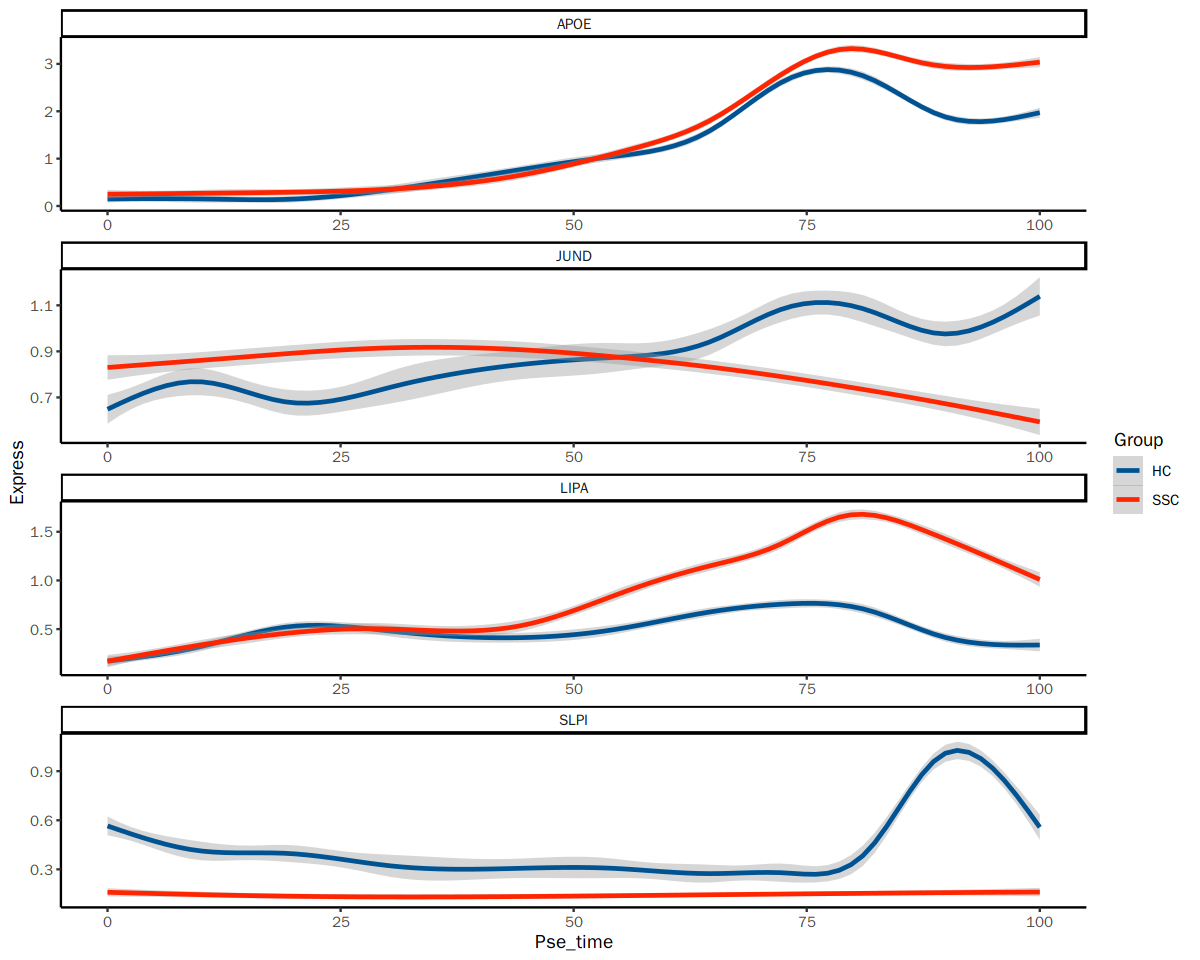

In [171]:
genes <- c('APOE',
           'LIPA',# DOI: 10.1161/ATVBAHA.117.310023， MD_Mac的 marker基因
           'JUND',# Jund is a determinant of macrophage activation
           'SLPI')
gene.seurat <- pseu.l[['RNA']]@data[genes,] %>% 
                                    as.matrix() %>%
                                    t() %>% 
                                    as.data.frame() %>% 
                                    tibble::rownames_to_column(var='Cell') %>% 
                                    left_join(metadata, var='Cell')  %>% 
                                    pivot_longer(!c(Cell,'APOE','LIPA','JUND','SLPI',Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
                                    pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')


ggplot(data = gene.seurat, aes(x=Pse_time, y=Express, group = Group, color=Group))+ 
  geom_smooth()+
  scale_colour_manual(values = c("#005393","#ff2500"))+
  theme_classic()+
  facet_wrap(~Gene, nrow=6, scales = 'free')
ggsave('./figures/L3_RNA.pdf',width = 5, height = 12)

Joining, by = "Cell"
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
“Removed 1882 rows containing non-finite values (stat_smooth).”
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
“Removed 1882 rows containing non-finite values (stat_smooth).”


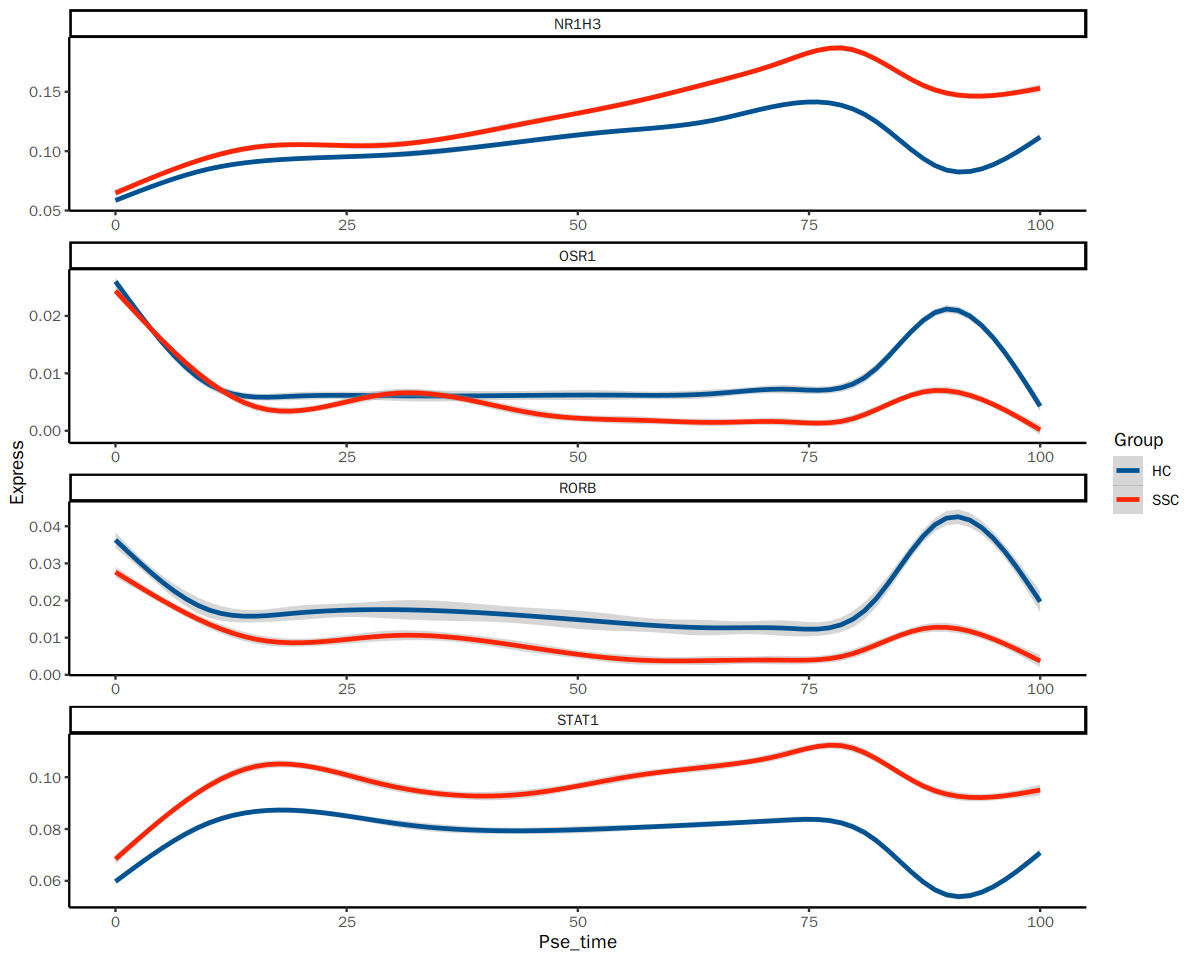

In [172]:
tfs <- c('NR1H3','STAT1','OSR1','RORB')
tf.seurat <- pseu.l[['TF']]@data[tfs,] %>% 
                                    as.matrix() %>%
                                    t() %>% 
                                    as.data.frame() %>% 
                                    tibble::rownames_to_column(var='Cell') %>% 
                                    left_join(metadata, var='Cell') %>% 
                                    pivot_longer(!c(Cell,'NR1H3','STAT1','OSR1','RORB',Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
                                    pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

# colnames(tf.seurat) <- gsub('[-]', '_', colnames(tf.seurat))
# tfs <- gsub('[-]', '_', tfs)
ggplot(data = tf.seurat, aes(x=Pse_time, y=Express, group = Group, color=Group))+ 
  geom_smooth()+
  scale_colour_manual(values = c("#005393","#ff2500"))+
  theme_classic()+
  facet_wrap(~Gene, nrow=6, scales = 'free')
ggsave('./figures/L3_TF.pdf',width = 5, height = 12)

Joining, by = "Cell"
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



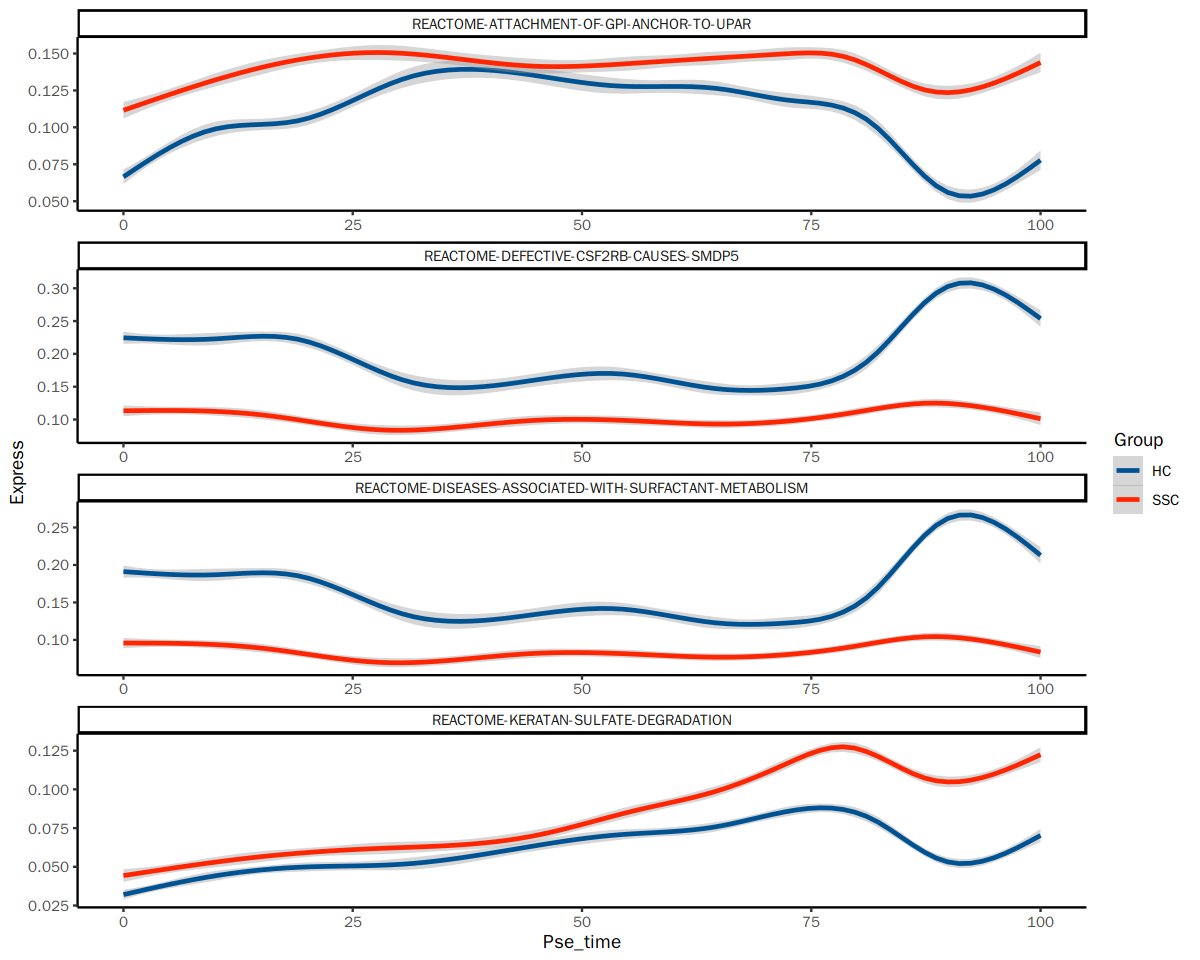

In [173]:
auc <- c(
        'REACTOME-DISEASES-ASSOCIATED-WITH-SURFACTANT-METABOLISM',
    'REACTOME-KERATAN-SULFATE-DEGRADATION',
    'REACTOME-ATTACHMENT-OF-GPI-ANCHOR-TO-UPAR',# attached to the plasma membrane, 应该是与抗原递呈相关
    
    'REACTOME-DEFECTIVE-CSF2RB-CAUSES-SMDP5') #https://reactome.org/content/detail/R-HSA-5688849#:~:text=Defects%20in%20human%20CSF2RB%20can%20cause%20pulmonary%20surfactant,%28Greenhill%20%26%20Kotton%202009%2C%20Whitsett%20et%20al.%202015%29.
auc.seurat <- pseu.l[['AUC']]@data[auc,] %>% 
                                    as.matrix() %>%
                                    t() %>% 
                                    as.data.frame() %>% 
                                    tibble::rownames_to_column(var='Cell') %>% 
                                    left_join(metadata, var='Cell') %>% 
                                    pivot_longer(!c(Cell,   
                                                           'REACTOME-DISEASES-ASSOCIATED-WITH-SURFACTANT-METABOLISM',
    'REACTOME-KERATAN-SULFATE-DEGRADATION',
    'REACTOME-ATTACHMENT-OF-GPI-ANCHOR-TO-UPAR',# attached to the plasma membrane, 应该是与抗原递呈相关
    'REACTOME-DEFECTIVE-CSF2RB-CAUSES-SMDP5',Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
                                    pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

colnames(auc.seurat) <- gsub('[-]', '_', colnames(auc.seurat))
auc <- gsub('[-]', '_', auc)
ggplot(data = auc.seurat, aes(x=Pse_time, y=Express, group = Group, color=Group))+ 
  geom_smooth()+
  scale_colour_manual(values = c("#005393","#ff2500"))+
  theme_classic()+
  facet_wrap(~Gene, nrow=6, scales = 'free')
ggsave('./figures/L3_AUC.pdf',width = 8, height = 12)

In [5]:
# --- Create Scoupe_Loom file
library(SCopeLoomR)
library(hdf5r)
# --- 01 Create a loom file
build_loom(file.name = "immune.loom",
        dgem = immune@assays$RNA@counts,
        title = "myeloid",
        default.embedding = immune@reductions$umap@cell.embeddings,
        default.embedding.name = "umap.rna")

loom <- open_loom("immune.loom", mode = "r+")
# --- 02 Add hierachy
add_hierarchy(
  loom = loom,
  hierarchy = create_hierarchy(
    level.1.name = "SSc-ILD",
    level.2.name = "Lung-myeloid"
  )
)
# --- 03 Add embedding(s)
add_embedding(loom = loom, 
              embedding = immune@reductions$pca@cell.embeddings,
              name = "pca")

# --- 04 Add MetaDate
names(loom[["col_attrs"]])
add_col_attr(loom = loom, key = "Sample", value = immune@meta.data$SamNum, as.annotation = TRUE)
add_col_attr(loom = loom, key = "Group", value = immune@meta.data$Group, as.annotation = TRUE)
add_col_attr(loom = loom, key = "Site", value = immune@meta.data$Site, as.annotation = TRUE)
add_col_attr(loom = loom, key = "Age", value = immune@meta.data$Age, as.annotation = TRUE)
add_col_attr(loom = loom, key = "Gender", value = immune@meta.data$Gender, as.annotation = TRUE)
add_col_attr(loom = loom, key = "Cohort", value = immune@meta.data$Cohort, as.annotation = TRUE)

immune@meta.data$mo_CellType <- as.character(immune@meta.data$mo_CellType)
add_col_attr(loom = loom, key = "CellType", value = immune@meta.data$mo_CellType, as.annotation = TRUE)

names(loom[["col_attrs"]])

# --- 05 Add Seurat clusters and markers
add_seurat_clustering(loom = loom,
        seurat = immune,
        seurat.assay = "RNA",
        seurat.clustering.prefix = "celltype.res.",
        seurat.markers.file.path.list = 
          list(celltype.res.0.1 = './SnnGenes/ct_res.0.1.rds.gz'),
        seurat.marker.metric.accessors = c("avg_log2FC", "p_val"),
        seurat.marker.metric.names = c("Avg. log2FC", "P-value"),
        seurat.marker.metric.description = c("Average log fold change", "Adjusted p-value (BF)")
)

# --- 06 save loom file
close_loom(loom)


载入程辑包：‘SCopeLoomR’


The following object is masked from ‘package:base’:

    flush



载入程辑包：‘hdf5r’


The following object is masked from ‘package:SummarizedExperiment’:

    values


The following object is masked from ‘package:GenomicRanges’:

    values


The following object is masked from ‘package:S4Vectors’:

    values


The following object is masked from ‘package:purrr’:

    flatten_df




[1] "Adding global attributes..."
[1] "Adding matrix..."
  |======================================================================| 100%[1] "Adding column attributes..."
[1] "Adding default metrics nUMI..."
[1] "Adding default metrics nGene..."
[1] "Adding default embedding..."
[1] "Adding row attributes..."
[1] "Adding columns graphs..."
[1] "Adding row graphs..."
[1] "Adding layers..."
[1] "Adding embedding pca..."


[1] "CellID"       "Embedding"    "Embeddings_X" "Embeddings_Y" "nGene"       
[6] "nUMI"

[1] "Age"          "CellID"       "CellType"     "Cohort"       "Embedding"   
 [6] "Embeddings_X" "Embeddings_Y" "Gender"       "Group"        "Sample"      
[11] "Site"         "nGene"        "nUMI"

[1] "Seurat, celltype.res.0.1"
[1] "Adding Seurat clusters..."
[1] "Clusterings created..."
[1] "Clustering ID: 0"
[1] "Adding Seurat markers..."
[1] "Adding markers for clustering 0..."
[1] "Adding metrics for clustering 0..."
